## Содержание <a name="introduction"></a>

1. [Описание проекта, описание данных, загрузка и импорт библиотек](#paragraph1)


2. [Загрузка и изучение данных:](#paragraph2)

   2.1 [Таблица visits](#paragraph2-1)
   
   2.2 [Таблица orders](#paragraph2-2)
   
   2.3 [Таблица costs](#paragraph2-3)
   
   
3. [Анализ данных по продукту](#paragraph3)

   3.1 [Подготовка данных](#paragraph3-1)
   
   3.2 [Визуализация и выводы](#paragraph3-2)
   
   3.3 [Retention Heatmap (с относительными и абсолютными величинами)](#paragraph3-3)
   

4. [Анализ данных по продажам](#paragraph4)

   4.1 [Когда люди начинают покупать?](#paragraph4-1)
   
   4.2 [Сколько раз покупают за период?](#paragraph4-2)
   
   4.3 [Какой средний чек?](#paragraph4-3)
   
   4.4 [Сколько денег приносят? (LTV)](#paragraph4-4) 
   

5. [Анализ данных по маркетингу](#paragraph5)

   5.1 [Сколько денег потратили? Всего / на каждый источник / по времени?](#paragraph5-1)
   
   5.2 [Анализ посещаемости ресурса по типу устройства](#paragraph5-2)
   
   5.3 [CAC, ROMI](#paragraph5-3)
   
   
6. [Общий вывод](#paragraph6)

## Загрузка библиотек

In [1]:
!pip install bokeh

In [2]:
!pip install pandas-bokeh

## 1. Описание проекта <a name="paragraph1"></a>

[Содержание](#introduction)

Мы стажируемся на работу в отдел аналитики J.K.. Было получение задание помочь маркетологам оптимизировать маркетинговые затраты.

В распоряжении есть данные от J.K. с июня 2017 по конец мая 2018 года:

- лог сервера с данными о посещениях сайта Яндекс.Афиши,;
- выгрузка всех заказов за этот период;
- статистика рекламных расходов.

### Описание данных¶

**Таблица visits** (лог сервера с информацией о посещениях сайта):

- **Uid** — уникальный id пользователя;
- **Device** — тип устройства пользователя;
- **Start Ts** — дата и время начала сессии;
- **End Ts** — дата и время окончания сессии;
- **Source Id** — id рекламного источника, из которого пришел пользователь.

**Таблица orders** (информация о заказах):

- **Uid** — уникальный id пользователя, который сделал заказ;
- **Buy Ts** — дата и время заказа;
- **Revenue** — выручка J.K. с этого заказа.

**Таблица costs** (информация о затратах на маркетинг):

- **source_id** — id рекламного источника;
- **dt** — дата;
- **costs** — затраты на этот рекламный источник в этот день.

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import seaborn as sns

In [4]:
from matplotlib.ticker import FuncFormatter
import datetime
import decimal
import io
import base64
from PIL import Image
import time

In [5]:
from bokeh.models.widgets import DataTable, DateFormatter, TableColumn, RadioButtonGroup, Select
from bokeh.plotting import ColumnDataSource, figure, show
from bokeh.io import output_file, reset_output, output_notebook
from bokeh.models.widgets import Tabs, Panel, Div
from bokeh.models import Span, Range1d, CustomJS, TextInput, HoverTool, FactorRange
from bokeh.models import WheelZoomTool, NumeralTickFormatter, Legend, BoxAnnotation
from bokeh.layouts import layout, row, column, widgetbox, gridplot
from bokeh.models import SingleIntervalTicker, LinearAxis, Label, Span, CheckboxGroup
from bokeh.transform import dodge
output_notebook()

Loading BokehJS ...

In [6]:
visits = pd.read_csv('/datasets/visits_log.csv')
orders = pd.read_csv('/datasets/orders_log.csv')
costs = pd.read_csv('/datasets/costs.csv')

### 2.1. Смотрим таблицу visits:  <a name="paragraph2-1"></a>

[Содержание](#introduction)

In [7]:
visits.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 359400 entries, 0 to 359399
Data columns (total 5 columns):
 #   Column     Non-Null Count   Dtype 
---  ------     --------------   ----- 
 0   Device     359400 non-null  object
 1   End Ts     359400 non-null  object
 2   Source Id  359400 non-null  int64 
 3   Start Ts   359400 non-null  object
 4   Uid        359400 non-null  uint64
dtypes: int64(1), object(3), uint64(1)
memory usage: 13.7+ MB


In [8]:
visits.head()

,Device,End Ts,Source Id,Start Ts,Uid
0,touch,2017-12-20 17:38:00,4,2017-12-20 17:20:00,16879256277535980062
1,desktop,2018-02-19 17:21:00,2,2018-02-19 16:53:00,104060357244891740
2,touch,2017-07-01 01:54:00,5,2017-07-01 01:54:00,7459035603376831527
3,desktop,2018-05-20 11:23:00,9,2018-05-20 10:59:00,16174680259334210214
4,desktop,2017-12-27 14:06:00,3,2017-12-27 14:06:00,9969694820036681168


In [9]:
visits = visits.rename(columns={'End Ts': 'session_end', 'Start Ts': 'session_start'})
visits.columns = visits.columns.str.lower()

Столбцы **session_start** и **session_end** имеют тип **object**, хотя там дата и время. Изменим формат данных:

In [10]:
visits['session_start'] = pd.to_datetime(visits['session_start'])
visits['session_end'] = pd.to_datetime(visits['session_end'])

### 2.2. Смотрим таблицу orders:  <a name="paragraph2-2"></a>

[Содержание](#introduction)

In [11]:
orders.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50415 entries, 0 to 50414
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   Buy Ts   50415 non-null  object 
 1   Revenue  50415 non-null  float64
 2   Uid      50415 non-null  uint64 
dtypes: float64(1), object(1), uint64(1)
memory usage: 1.2+ MB


In [12]:
orders.head()

,Buy Ts,Revenue,Uid
0,2017-06-01 00:10:00,17.00,10329302124590727494
1,2017-06-01 00:25:00,0.55,11627257723692907447
2,2017-06-01 00:27:00,0.37,17903680561304213844
3,2017-06-01 00:29:00,0.55,16109239769442553005
4,2017-06-01 07:58:00,0.37,14200605875248379450


In [13]:
orders = orders.rename(columns={'Buy Ts': 'date_of_purchase'})
orders.columns = orders.columns.str.lower()

Столбец **date_of_purchase** имеет тип **object**, хотя там дата и время. Изменим формат данных:

In [14]:
orders['date_of_purchase'] = pd.to_datetime(orders['date_of_purchase'])

In [15]:
orders.dtypes

date_of_purchase    datetime64[ns]
revenue                    float64
uid                         uint64
dtype: object

По столбцу **revenue** не указаны единицы измерения. Предполагаю, что в **"тыс.руб."**, учитывая то, какие, в среднем, значения там присутствуют. Будем использовать и дальше данную величину.

Также создадим копию датафрейма **orders**, где даты будут не дневные, а месячные. В дальнейшем нам этот датафрейм понадобится в работе:

In [16]:
orders_monthly = orders.copy()
orders_monthly['date_of_purchase'] = orders_monthly['date_of_purchase'].astype('datetime64[M]')

### 2.3. Смотрим таблицу costs:  <a name="paragraph2-3"></a>

[Содержание](#introduction)

In [17]:
costs.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2542 entries, 0 to 2541
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   source_id  2542 non-null   int64  
 1   dt         2542 non-null   object 
 2   costs      2542 non-null   float64
dtypes: float64(1), int64(1), object(1)
memory usage: 59.7+ KB


In [18]:
costs.head(10)

,source_id,dt,costs
0,1,2017-06-01,75.20
1,1,2017-06-02,62.25
2,1,2017-06-03,36.53
3,1,2017-06-04,55.00
4,1,2017-06-05,57.08
5,1,2017-06-06,40.39
6,1,2017-06-07,40.59
7,1,2017-06-08,56.63
8,1,2017-06-09,40.16
9,1,2017-06-10,43.24


In [19]:
costs = costs.rename(columns={'dt': 'date'})
costs.columns = costs.columns.str.lower()

Столбец date имеет тип **object**, хотя там дата и время. Изменим:

In [20]:
costs['date'] = pd.to_datetime(costs['date'], format='%Y-%m-%d')

## 3. Анализ данных по продукту  <a name="paragraph3"></a>

[Содержание](#introduction)

Рассмотрим следующие вопросы:
- Сколько людей пользуются в день, неделю, месяц?
- Сколько сессий в день?
- Сколько длится одна сессия?
- Как часто люди возвращаются?

### 3.1. Подготовка данных:  <a name="paragraph3-1"></a>

In [21]:
visits.head(10)

,device,session_end,source id,session_start,uid
0,touch,2017-12-20 17:38:00,4,2017-12-20 17:20:00,16879256277535980062
1,desktop,2018-02-19 17:21:00,2,2018-02-19 16:53:00,104060357244891740
2,touch,2017-07-01 01:54:00,5,2017-07-01 01:54:00,7459035603376831527
3,desktop,2018-05-20 11:23:00,9,2018-05-20 10:59:00,16174680259334210214
4,desktop,2017-12-27 14:06:00,3,2017-12-27 14:06:00,9969694820036681168
5,desktop,2017-09-03 21:36:00,5,2017-09-03 21:35:00,16007536194108375387
6,desktop,2018-01-30 12:09:00,1,2018-01-30 11:13:00,6661610529277171451
7,touch,2017-11-05 15:15:00,3,2017-11-05 15:14:00,11423865690854540312
8,desktop,2017-07-19 10:44:00,3,2017-07-19 10:41:00,2987360259350925644
9,desktop,2017-11-08 13:43:00,5,2017-11-08 13:42:00,1289240080042562063


Будем работать с датафреймом **visits**. Для ответа на вопросы по каждой строке добавим информацию по дню недели сессии, по номеру недели и по месяцу. Также добавим столбец с длительностью сессии (в минутах):

In [22]:
#visits['session_umd'] = visits['session_start'].dt.date
visits['session_umd'] = visits['session_start'].astype('datetime64[D]')
#visits['session_week'] = visits['session_start'].dt.week
visits['session_week'] = visits['session_start'].astype('datetime64[W]')
#visits['session_month'] = visits['session_start'].dt.to_period('M')
visits['session_month'] = visits['session_start'].astype('datetime64[M]')
visits['session_duration'] = visits['session_end'] - visits['session_start']
visits['session_duration'] = visits['session_duration'].apply(lambda x: decimal.Decimal(x.seconds) // 60)
visits['session_duration'] = visits['session_duration'].astype('int')

### 3.2. Визуализация и выводы  <a name="paragraph3-2"></a>

In [23]:
visits_day = visits.groupby('session_umd').agg({'uid':'nunique'})             
print('Среднее кол-во пользователей в день:', visits_day.mean().round())
visits_week = visits.groupby('session_week').agg({'uid':'nunique'})             
print('Среднее кол-во пользователей в неделю:', visits_week.mean().round())
visits_month = visits.groupby('session_month').agg({'uid':'nunique'})             
print('Среднее кол-во пользователей в месяц:', visits_month.mean().round()) 

Среднее кол-во пользователей в день: uid    908.0
dtype: float64
Среднее кол-во пользователей в неделю: uid    5724.0
dtype: float64
Среднее кол-во пользователей в месяц: uid    23228.0
dtype: float64


In [24]:
df_to_plot_visits_count_day = visits.groupby('session_umd')['uid'].count().reset_index()
visits_d = df_to_plot_visits_count_day.groupby('session_umd').agg({'uid':'sum'}).mean().round()           
print('Среднее кол-во сессий в день:', visits_d)
df_to_plot_visits_count_day.head(10)

Среднее кол-во сессий в день: uid    987.0
dtype: float64


,session_umd,uid
0,2017-06-01,664
1,2017-06-02,658
2,2017-06-03,477
3,2017-06-04,510
4,2017-06-05,893
5,2017-06-06,875
6,2017-06-07,788
7,2017-06-08,939
8,2017-06-09,755
9,2017-06-10,375


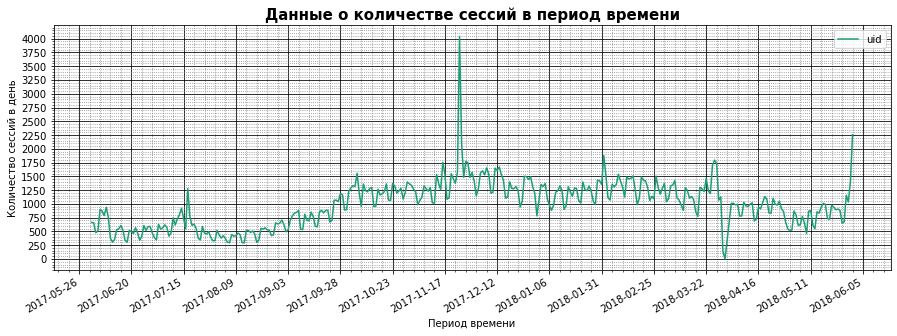

In [25]:
fig, ax = plt.subplots(figsize=(15, 5))
x = ('session_umd')
y1 = ('uid')
df_to_plot_visits_count_day.plot(x, y1, ax = ax, colormap='Dark2', rot = 30)

#  Устанавливаем интервал основных и
#  вспомогательных делений:
ax.xaxis.set_major_locator(ticker.MultipleLocator(25))
ax.xaxis.set_minor_locator(ticker.MultipleLocator(10))
ax.yaxis.set_major_locator(ticker.MultipleLocator(250))
ax.yaxis.set_minor_locator(ticker.MultipleLocator(200))


#  Добавляем линии основной сетки:
ax.grid(which='major',
        color = 'k')

#  Включаем видимость вспомогательных делений:
ax.minorticks_on()
#  Теперь можем отдельно задавать внешний вид
#  вспомогательной сетки:
ax.grid(which='minor',
        color = 'gray',
        linestyle = ':')


plt.title('Данные о количестве сессий в период времени', fontsize=15, fontweight='bold')
plt.xlabel('Период времени')
plt.ylabel('Количество сессий в день');

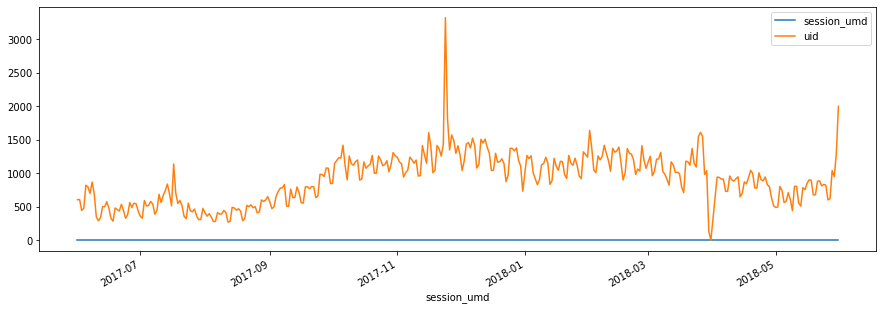

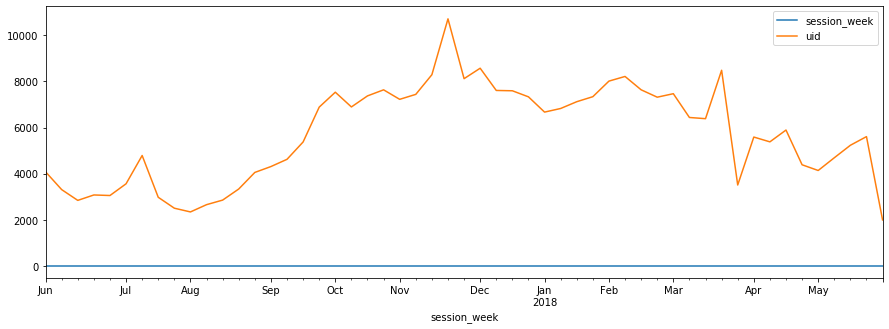

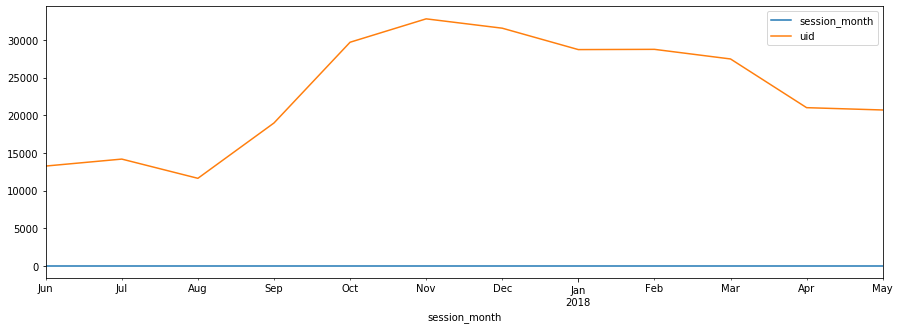

In [26]:
visits.pivot_table(index = 'session_umd', values = 'uid', aggfunc = 'nunique').plot(figsize=(15, 5))
visits.pivot_table(index = 'session_week', values = 'uid', aggfunc = 'nunique').plot(figsize=(15, 5))
visits.pivot_table(index = 'session_month', values = 'uid', aggfunc = 'nunique').plot(figsize=(15, 5)) 

### Сколько людей пользуются нашим ресурсом в день, неделю, месяц?.
- **DAU:** 908 пользователей
- **WAU:** 5724 пользователя
- **MAU:** 23228 пользователей

### Сколько сессий в день?.
- **Day visits**: 987
В среднем каждый пользователь заходит на ресурс лишь 1 раз в день

Показатель **DAU** — количество посетителей за день, **WAU** — за неделю и **MAU** — за месяц. В подсчете участвуют только уникальные пользователи, повторные визиты не считаются. Если человек ежедневно использует приложение, его считают каждый день для **DAU** и один раз для **WAU** или **MAU**. Для рекламной компании наиболее важна метрика **DAU** (стремимся максимально удерживать пользователя каждый день).

In [27]:
visits.head()

,device,session_end,source id,session_start,uid,session_umd,session_week,session_month,session_duration
0,touch,2017-12-20 17:38:00,4,2017-12-20 17:20:00,16879256277535980062,2017-12-20,2017-12-14,2017-12-01,18
1,desktop,2018-02-19 17:21:00,2,2018-02-19 16:53:00,104060357244891740,2018-02-19,2018-02-15,2018-02-01,28
2,touch,2017-07-01 01:54:00,5,2017-07-01 01:54:00,7459035603376831527,2017-07-01,2017-06-29,2017-07-01,0
3,desktop,2018-05-20 11:23:00,9,2018-05-20 10:59:00,16174680259334210214,2018-05-20,2018-05-17,2018-05-01,24
4,desktop,2017-12-27 14:06:00,3,2017-12-27 14:06:00,9969694820036681168,2017-12-27,2017-12-21,2017-12-01,0


In [28]:
df_to_plot_orders_meanprice = orders.copy()
df_to_plot_orders_meanprice['date_of_purchase'] = df_to_plot_orders_meanprice['date_of_purchase'].dt.date
    
df_to_plot_orders = df_to_plot_orders_meanprice.groupby('date_of_purchase')['uid'].count().reset_index()
df_to_plot_sum_orders = df_to_plot_orders_meanprice.groupby('date_of_purchase')['revenue'].sum().reset_index()
df_to_plot_meanprice = df_to_plot_orders_meanprice.groupby('date_of_purchase')['revenue'].mean().reset_index()

In [29]:
# revenue_costs
df_to_plot_costs = costs.copy()
df_to_plot_costs['date'] = df_to_plot_costs['date'].dt.date
df_to_plot_costs = df_to_plot_costs.rename(columns={'date': 'date_of_purchase'})

df_to_plot_costs = df_to_plot_costs.groupby('date_of_purchase')['costs'].sum().reset_index()
df_to_plot_costs = df_to_plot_sum_orders.merge(df_to_plot_costs, on = 'date_of_purchase')

In [30]:
df_to_plot_costs.head()

,date_of_purchase,revenue,costs
0,2017-06-01,389.46,735.26
1,2017-06-02,324.11,721.19
2,2017-06-03,166.48,450.85
3,2017-06-04,195.21,761.16
4,2017-06-05,441.49,821.44


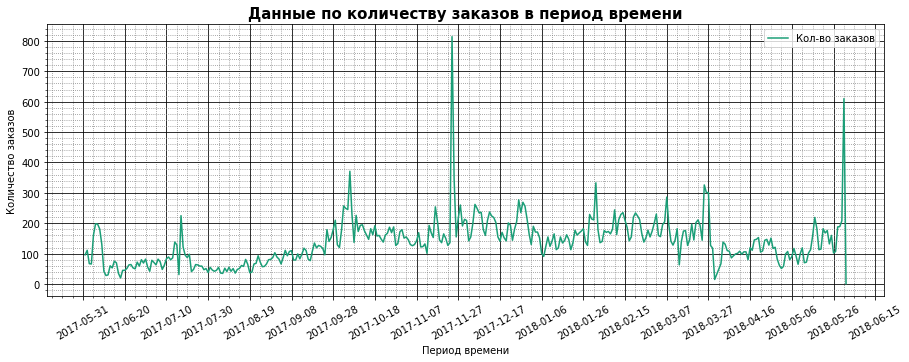

In [31]:
df_to_plot_orders.pivot_table(index = 'date_of_purchase', values = 'uid')

fig, ax = plt.subplots(figsize=(15, 5))
x = ('date_of_purchase')
y = ('uid')
df_to_plot_orders.plot(x, y, ax = ax, colormap='Dark2', rot = 30)

#  Устанавливаем интервал основных и
#  вспомогательных делений:
ax.xaxis.set_major_locator(ticker.MultipleLocator(20))
ax.xaxis.set_minor_locator(ticker.MultipleLocator(10))
ax.yaxis.set_major_locator(ticker.MultipleLocator(100))
ax.yaxis.set_minor_locator(ticker.MultipleLocator(200))


#  Добавляем линии основной сетки:
ax.grid(which='major',
        color = 'k')

#  Включаем видимость вспомогательных делений:
ax.minorticks_on()
#  Теперь можем отдельно задавать внешний вид
#  вспомогательной сетки:
ax.grid(which='minor',
        color = 'gray',
        linestyle = ':')
ax.legend(['Кол-во заказов'])
plt.title('Данные по количеству заказов в период времени', fontsize=15, fontweight='bold')
plt.xlabel('Период времени')
plt.ylabel('Количество заказов');

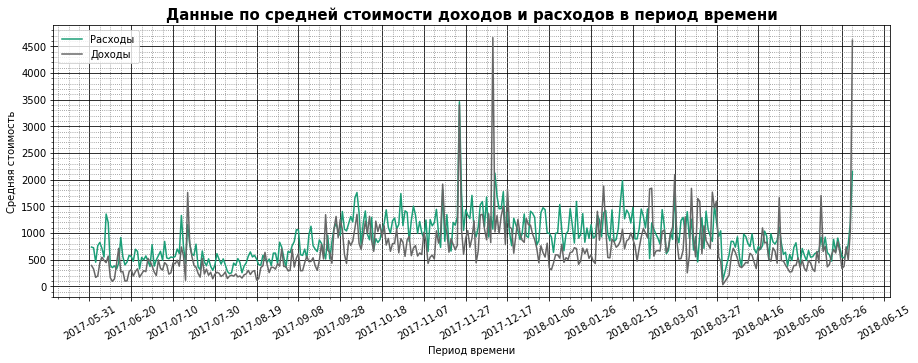

In [32]:
fig, ax = plt.subplots(figsize=(15, 5))
x = ('date_of_purchase')
y1 = ['costs', 'revenue']
df_to_plot_costs.plot(x, y1, ax = ax, colormap='Dark2', rot = 30)

#  Устанавливаем интервал основных и
#  вспомогательных делений:
ax.xaxis.set_major_locator(ticker.MultipleLocator(20))
ax.xaxis.set_minor_locator(ticker.MultipleLocator(10))
ax.yaxis.set_major_locator(ticker.MultipleLocator(500))
ax.yaxis.set_minor_locator(ticker.MultipleLocator(500))


#  Добавляем линии основной сетки:
ax.grid(which='major',
        color = 'k')

#  Включаем видимость вспомогательных делений:
ax.minorticks_on()
#  Теперь можем отдельно задавать внешний вид
#  вспомогательной сетки:
ax.grid(which='minor',
        color = 'gray',
        linestyle = ':')
ax.legend(['Расходы', 'Доходы'])
plt.title('Данные по средней стоимости доходов и расходов в период времени', fontsize=15, fontweight='bold')
plt.xlabel('Период времени')
plt.ylabel('Средняя стоимость');

### Вывод:
Как  видно из графика компания убыточная, **прибыль** (разница между доходами и расходами) у компании отсутствует. Т.к. уровень расходов привышает уровень доходов. Правдо есть аномальные выбросы по дневнысм доходам. 

<table border="1" cellspacing="0" cellpadding="0">
<tr>
<td><b>Дата события</b></td>
<td><b>Доходы, т.р.</b></td>
<td><b>Расходы, т.р.</b></td>
<tr>

<td> <b>14 июля 2017г.</b></td>
<td>700<span style="color:green">&#x2796;</span></td>
<td>1300<span style="color:red">&#x25B2;</span></td>
<tr>
    
<td> <b>17 июля 2017г.</b></td>
<td>1750<span style="color:green">&#x25B2;</span></td>
<td>1150<span style="color:red">&#x25B2;</span></td>
<tr>
    
<td> <b>28 октября 2017г.</b></td>
<td>900<span style="color:red">&#x25BC;</span></td>
<td>1720<span style="color:red">&#x25B2;</span></td>
<tr>
    
<td> <b>22 ноября 2017г.</b></td>
<td>3500<span style="color:green">&#x25B2;</span><span style="color:green">&#x25B2;</span></td>
<td>3450<span style="color:red">&#x25B2;</span><span style="color:red">&#x25B2;</span></td>
<tr>
    
<td> <b>10 декабря 2017г.</b></td>
<td>4700<span style="color:green">&#x25B2;</span></td>
<td>1100<span style="color:green">&#x2796;</span></td>
<tr>
    
<td> <b>30-31 марта 2018г.</b></td>
<td>50<span style="color:red">&#x25BC;</span><span style="color:red">&#x25BC;</span></td>
<td>20<span style="color:green">&#x25BC;</span><span style="color:green">&#x25BC;</span></td>
<tr>
    
<td> <b>31 мая 2018г.</b></td>
<td>4600<span style="color:green">&#x25B2;</span></td>
<td>2150<span style="color:red">&#x25B2;</span></td>
</table>

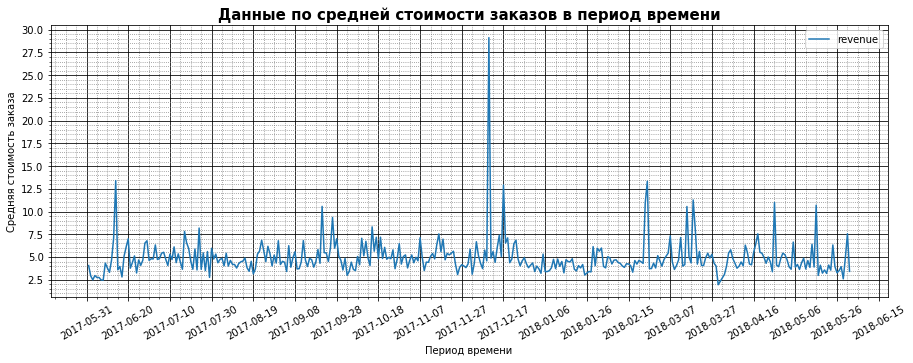

In [33]:
df_to_plot_meanprice.pivot_table(index = 'date_of_purchase', values = 'revenue')

fig, ax = plt.subplots(figsize=(15, 5))
x = ('date_of_purchase')
y = ('revenue')
df_to_plot_meanprice.plot(x, y, ax = ax, rot = 30)

#  Устанавливаем интервал основных и
#  вспомогательных делений:
ax.xaxis.set_major_locator(ticker.MultipleLocator(20))
ax.xaxis.set_minor_locator(ticker.MultipleLocator(10))
ax.yaxis.set_major_locator(ticker.MultipleLocator(2.5))
ax.yaxis.set_minor_locator(ticker.MultipleLocator(200))


#  Добавляем линии основной сетки:
ax.grid(which='major',
        color = 'k')

#  Включаем видимость вспомогательных делений:
ax.minorticks_on()
#  Теперь можем отдельно задавать внешний вид
#  вспомогательной сетки:
ax.grid(which='minor',
        color = 'gray',
        linestyle = ':')

plt.title('Данные по средней стоимости заказов в период времени', fontsize=15, fontweight='bold')
plt.xlabel('Период времени')
plt.ylabel('Средняя стоимость заказа');

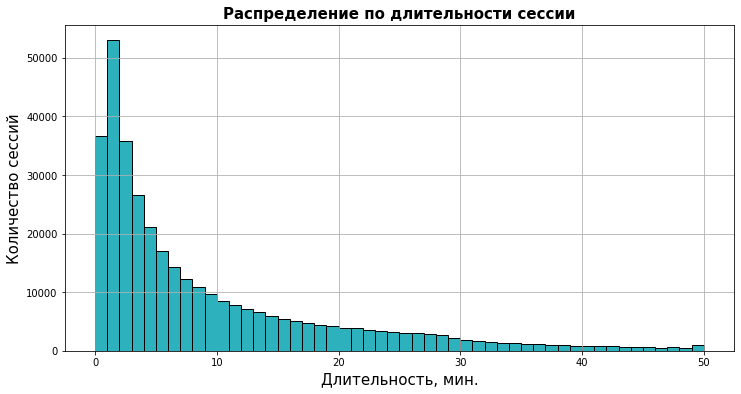

In [34]:
first_order_hist = visits.query('session_duration <= 50')['session_duration'].hist(bins=50, figsize=(12, 6),
                                                                                   color="#2db1bd", ec='black')


plt.title('Распределение по длительности сессии', fontsize=15, fontweight='bold')
plt.xlabel('Длительность, мин.', fontsize=15)
plt.ylabel('Количество сессий', fontsize=15);

### Сколько длится одна сессия?
**Продолжительность в основном сессий** - от 0 до 3 минут. Дительность сессий очень маленькая.

Text(0, 1, 'Удержание')

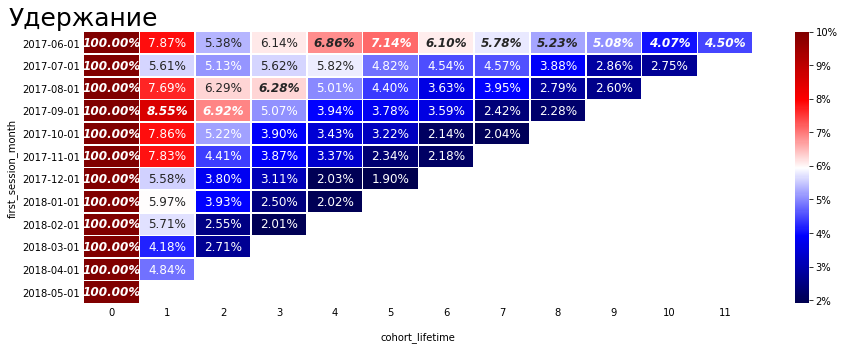

In [35]:
    # retention heatmap
first_session_date_by_customers = visits.groupby('uid')['session_start'].min()
first_session_date_by_customers.name = 'first_session_month'
df_retention = visits.join(first_session_date_by_customers, on='uid')
df_retention['first_session_month'] = df_retention['first_session_month'].astype('datetime64[M]')
df_retention['session_month'] = df_retention['session_start'].astype('datetime64[M]')
df_retention['cohort_lifetime'] = df_retention['session_month'] - df_retention['first_session_month']
df_retention['cohort_lifetime'] = df_retention['cohort_lifetime'] / np.timedelta64(1,'M')
df_retention['cohort_lifetime'] = df_retention['cohort_lifetime'].round().astype('int')

cohorts = (df_retention
                       .groupby(['first_session_month', 'cohort_lifetime'])
                       .agg({'uid': 'nunique'})
                       .reset_index()
              )

initial_users_count = cohorts[cohorts['cohort_lifetime']==0][['first_session_month', 'uid']]
initial_users_count = initial_users_count.rename(columns={'uid': 'cohort_users'})

cohorts = cohorts.merge(initial_users_count, on='first_session_month')
cohorts['retention'] = cohorts['uid']/cohorts['cohort_users']

retention_pivot = cohorts.pivot_table(index='first_session_month', columns='cohort_lifetime',
                                      values='retention', aggfunc='sum')

max_in_each_column = np.max(retention_pivot, axis=0)
plt.figure(figsize=(15,5))
    
fmt = lambda x,pos: '{:.0%}'.format(x)
heatmap = sns.heatmap(retention_pivot, annot=True, fmt='.2%', cmap='seismic', vmax=0.10, linewidths=.5,
                      mask=retention_pivot == max_in_each_column, annot_kws={"size": 12}, 
                      cbar_kws={'format': FuncFormatter(fmt)})


heatmap = sns.heatmap(retention_pivot, annot=True, fmt='.2%', cmap='seismic', vmax=0.10, linewidths=.5,
                      mask=retention_pivot != max_in_each_column,
                      annot_kws={"style": "italic", "weight": "bold", "size": 12},
                      cbar=False)
y_labels = heatmap.set_yticklabels(retention_pivot.index.date)
#heatmap.xaxis.tick_top()
#heatmap.xaxis.set_label_position('top')
heatmap.xaxis.labelpad = 15
heatmap.tick_params(length=0)
plt.title('Удержание', x=0, fontsize=25)

### Как часто люди возвращаются?
Необходимо отметить, что **Retention** довольно низкий. **Retention** второго месяца пользования нашим ресурсом находится в интервале от 6 до 8,5% в зависимости от когорты. Причем после одного месяца пользователя, на второй, возвращается большая часть клиентов, далее, с течением времени, этот процент падает дальше.
Это справедливо для всех, кроме самой первой когорты, которая начала пользоваться ресурсом в июне 2017 года. Их **Retention** тоже довольно низкий, но постоянно находится в "лидерах" по сравнении со всеми остальными когортами.

Чем же эта первая когорта так особенна? - На этот вопрос необходимо искать ответ.


Помимо этого на графиках есть необычные всплески активности и, наоборот, провалы.

### 3.3. Retention Heatmap (с относительными и абсолютными величинами)  <a name="paragraph3-3"></a>

Для интереса, посмотрим на heatmap **Retention** с отображением одновременно и относительных, и абсолютных величин (в % и в количестве "оставшихся" из когорты пользователей):

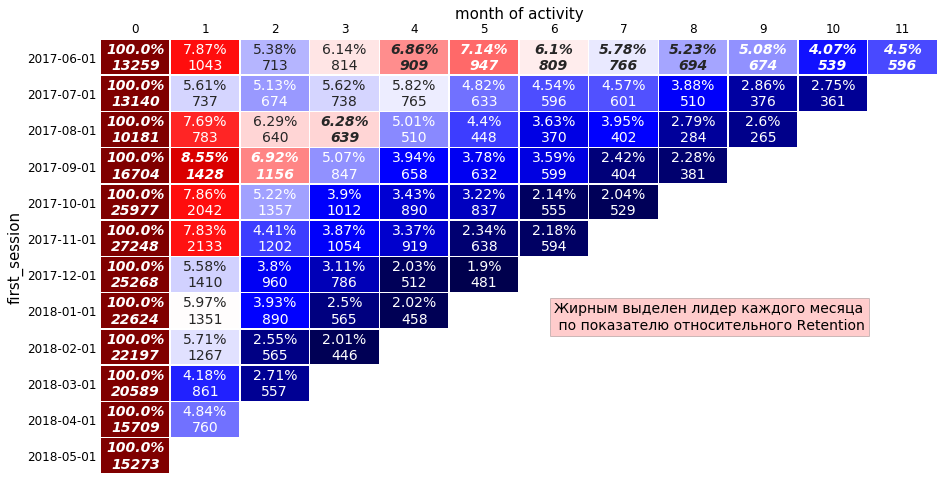

In [36]:
# получаем pivot'ы относительного и абсолютно Retention 

first_session_date = visits.groupby('uid')['session_start'].min()
first_session_date.name = 'first_session_month'
df_ret_prepare = visits.join(first_session_date, on='uid')
df_ret_prepare['first_session_month'] = df_ret_prepare['first_session_month'].astype('datetime64[M]')
df_ret_prepare['session_month'] = df_ret_prepare['session_start'].astype('datetime64[M]')
df_ret_prepare['cohort_lifetime'] = df_ret_prepare['session_month'] - df_ret_prepare['first_session_month']
df_ret_prepare['cohort_lifetime'] = df_ret_prepare['cohort_lifetime'] / np.timedelta64(1,'M')
df_ret_prepare['cohort_lifetime'] = df_ret_prepare['cohort_lifetime'].round().astype('int')

cohorts_ret = (df_ret_prepare
                       .groupby(['first_session_month', 'cohort_lifetime'])
                       .agg({'uid': 'nunique'})
                       .reset_index()
          )

init_users_count = cohorts_ret[cohorts_ret['cohort_lifetime']==0][['first_session_month', 'uid']]
init_users_count = init_users_count.rename(columns={'uid': 'cohort_users'})

cohorts_ret = cohorts_ret.merge(init_users_count, on='first_session_month')
cohorts_ret['retention'] = cohorts_ret['uid']/cohorts_ret['cohort_users']

retention_pivot_abs = cohorts_ret.pivot_table(index='first_session_month', columns='cohort_lifetime',
                                      values='uid', aggfunc='sum')
retention_pivot_rel = cohorts_ret.pivot_table(index='first_session_month', columns='cohort_lifetime',
                                      values='retention', aggfunc='sum')
retention_pivot_rel = (retention_pivot_rel * 100).round(2)

# создаем датафрейм, где в каждой ячейке фигурируют оба значения
df_retention_rel_abs = pd.DataFrame(index=retention_pivot_rel.index, columns=retention_pivot_rel.columns) 

for col in retention_pivot_rel.columns:
    first_part = retention_pivot_rel[col].astype('str') + '%' + '\n'
    second_part = retention_pivot_abs[col].astype('str').str.rstrip('0').str.rstrip('.')
    df_retention_rel_abs[col] = first_part + second_part
df_retention_rel_abs = df_retention_rel_abs.replace('nan%\nnan', '')

# строим heatmap
max_in_each_column_ret = np.max(retention_pivot_rel, axis=0)

plt.figure(figsize=(15,8))
# string_rel = ltv_pivot_revenue.values
# string_uid = retention_pivot_abs.values

heatmap_retention_rel_abs = sns.heatmap(retention_pivot_rel, fmt='', annot=df_retention_rel_abs.values, 
                                        cmap='seismic', linewidths=.5,
                                        mask=retention_pivot_rel == max_in_each_column_ret, cbar=False, vmax=10,
                                        annot_kws={"size": 14})


heatmap_retention_rel_abs = sns.heatmap(retention_pivot_rel, fmt='', annot=df_retention_rel_abs.values, 
                                        cmap='seismic', linewidths=.5,
                                        mask=retention_pivot_rel != max_in_each_column_ret,
                                        annot_kws={"style": "italic", "weight": "bold", "size": 14}, vmax=10,
                                        cbar=False)

y_labels_ret = heatmap_retention_rel_abs.set_yticklabels(retention_pivot_rel.index.date)
heatmap_retention_rel_abs.set_xlabel('month of activity', fontsize=15)
heatmap_retention_rel_abs.set_ylabel('first_session', fontsize=15)
heatmap_retention_rel_abs.tick_params(length=0)
heatmap_retention_rel_abs.set_xticklabels(heatmap_retention_rel_abs.get_xmajorticklabels(), fontsize = 12)
heatmap_retention_rel_abs.set_yticklabels(heatmap_retention_rel_abs.get_ymajorticklabels(), fontsize = 12)
heatmap_retention_rel_abs.xaxis.tick_top()
heatmap_retention_rel_abs.xaxis.set_label_position('top')
text_ret = plt.text(6.5, 8, 'Жирным выделен лидер каждого месяца\n по показателю относительного Retention',
                bbox=dict(facecolor='red', alpha=0.2),
                fontsize=14)

## 4. Анализ данных по продажам  <a name="paragraph4"></a>

[Содержание](#introduction)

- Когда люди начинают покупать?
- Сколько раз покупают за период?
- Какой средний чек?
- Сколько денег приносят? (LTV)

Работать будем с датафреймами **orders** и **visits**.

### 4.1. Когда люди начинают покупать?.  <a name="paragraph4-1"></a>

Сгруппируем датафрейм **orders** по пользователям, чтобы найти дату их первого заказа, и датафрейм **visits**, чтобы найти дату первой сессии:

In [37]:
first_purchase_date = orders.groupby('uid')[['date_of_purchase']].min().reset_index()
first_purchase_date.columns = ['uid', 'first_purchase_date']
first_session_date = visits.groupby('uid')[['session_start']].min().reset_index()
first_session_date.columns = ['uid', 'first_session']

Сведем данные в общим датафрейм:

In [38]:
when_they_buy = first_purchase_date.merge(first_session_date, on='uid')

In [39]:
when_they_buy.head()

,uid,first_purchase_date,first_session
0,313578113262317,2018-01-03 21:51:00,2017-09-18 22:49:00
1,1575281904278712,2017-06-03 10:13:00,2017-06-03 10:13:00
2,2429014661409475,2017-10-11 18:33:00,2017-10-11 17:14:00
3,2464366381792757,2018-01-28 15:54:00,2018-01-27 20:10:00
4,2551852515556206,2017-11-24 10:14:00,2017-11-24 10:14:00


Добавим столбец с разницей в минутах между датой и временем первого заказа и датой и временем первой сессии:

In [40]:
when_they_buy['buy_diff'] = when_they_buy['first_purchase_date'] - when_they_buy['first_session']
when_they_buy['buy_diff'] = when_they_buy['buy_diff']/np.timedelta64(1, 'm')
when_they_buy['buy_diff'] = when_they_buy['buy_diff'].round(1)
when_they_buy.head(10)

,uid,first_purchase_date,first_session,buy_diff
0,313578113262317,2018-01-03 21:51:00,2017-09-18 22:49:00,154022.0
1,1575281904278712,2017-06-03 10:13:00,2017-06-03 10:13:00,0.0
2,2429014661409475,2017-10-11 18:33:00,2017-10-11 17:14:00,79.0
3,2464366381792757,2018-01-28 15:54:00,2018-01-27 20:10:00,1184.0
4,2551852515556206,2017-11-24 10:14:00,2017-11-24 10:14:00,0.0
5,3077748354309989,2018-03-03 12:33:00,2018-03-03 12:08:00,25.0
6,3605148382144603,2017-09-21 20:56:00,2017-08-15 21:54:00,53222.0
7,3753586865891862,2018-03-03 13:50:00,2018-03-03 13:47:00,3.0
8,4808417689019433,2018-01-09 23:32:00,2018-01-09 23:10:00,22.0
9,4992223027560440,2018-04-04 13:54:00,2018-04-04 13:54:00,0.0


Сгруппируем датафрейм по пользователям и по каждому из них выберем минимальную разницу по времени (т.е. разницу между первой сессией и первой покупкой):

In [41]:
to_hist = when_they_buy.groupby('uid')[['buy_diff']].min()

Посмотрим на выбросы и построим гистограмму:

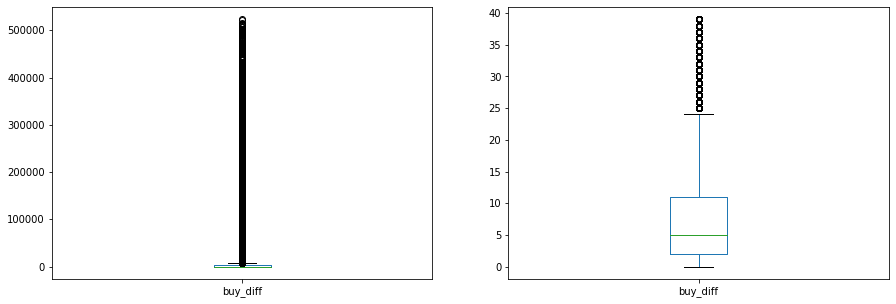

In [42]:
fig, axes = plt.subplots(1, 2, figsize=(15,5))

to_hist.plot(kind='box', ax=axes[0])
to_hist.query('buy_diff < 40').plot(kind='box', ax=axes[1]);

Выбросы начинаются с разницы по времени от 30 минут и более.

На основании этих данных построим гистограмму распределения этой разницы по времени

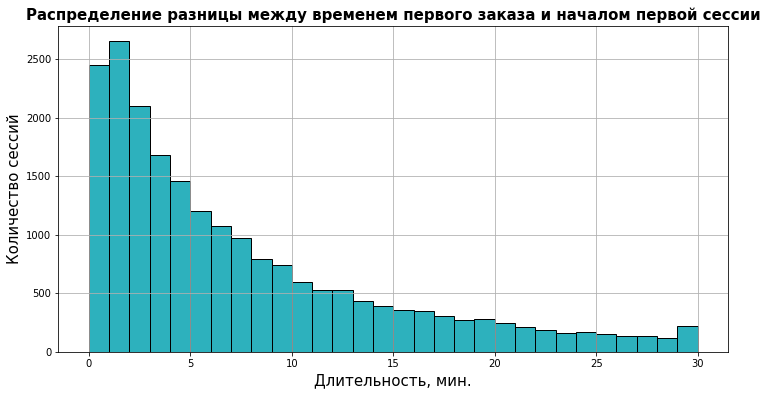

In [43]:
title = "Гистограмма распределения разницы между временем первого заказа и началом первой сессии"

first_order_hist = to_hist.query('buy_diff <= 30')['buy_diff'].hist(bins=30, figsize=(12, 6),
                                                                    color="#2db1bd", ec='black')

plt.title('Распределение разницы между временем первого заказа и началом первой сессии', fontsize=15, fontweight='bold')
plt.xlabel('Длительность, мин.', fontsize=15)
plt.ylabel('Количество сессий', fontsize=15);

**Вывод:** большая части пользователей на оформление заказа уходит не более 3 минут. Т.е. они заходят ресурс и сразу делают заказ. Видно, что заходят они сразу по делу.

### 4.2. Сколько раз покупают за период?.  <a name="paragraph4-2"></a>

За период возьмем месяц. Посмотрим, сколько каждый пользователь делает покупок за "свой" месяц.

In [44]:
orders.head()

,date_of_purchase,revenue,uid
0,2017-06-01 00:10:00,17.00,10329302124590727494
1,2017-06-01 00:25:00,0.55,11627257723692907447
2,2017-06-01 00:27:00,0.37,17903680561304213844
3,2017-06-01 00:29:00,0.55,16109239769442553005
4,2017-06-01 07:58:00,0.37,14200605875248379450


Сгруппируем по пользователям и найдем у каждого время первого заказа:

In [45]:
first_purchase = orders.groupby('uid')['date_of_purchase'].min().reset_index()
first_purchase.columns = ['uid', 'date_of_first_purchase']
order_frequency = pd.merge(orders, first_purchase, on='uid')
order_frequency.head(10)

,date_of_purchase,revenue,uid,date_of_first_purchase
0,2017-06-01 00:10:00,17.00,10329302124590727494,2017-06-01 00:10:00
1,2017-06-01 00:25:00,0.55,11627257723692907447,2017-06-01 00:25:00
2,2017-06-01 00:27:00,0.37,17903680561304213844,2017-06-01 00:27:00
3,2017-06-01 00:29:00,0.55,16109239769442553005,2017-06-01 00:29:00
4,2017-06-01 07:58:00,0.37,14200605875248379450,2017-06-01 07:58:00
5,2017-06-01 08:43:00,0.18,10402394430196413321,2017-06-01 08:43:00
6,2017-06-01 08:54:00,1.83,12464626743129688638,2017-06-01 08:54:00
7,2017-06-05 14:30:00,7.33,12464626743129688638,2017-06-01 08:54:00
8,2017-06-01 09:22:00,1.22,3644482766749211722,2017-06-01 09:22:00
9,2017-06-02 12:44:00,0.85,3644482766749211722,2017-06-01 09:22:00


Теперь добавим столбец time_difference, где будет в месяцах указано время "пребывания" каждого пользователя с момента первого визита на момент конкретного заказа:

In [46]:
def diff_month(row):
    date1 = row['date_of_purchase']
    date2 = row['date_of_first_purchase']
    return (date1.year - date2.year) * 12 + date1.month - date2.month

order_frequency['time_difference'] = order_frequency.apply(diff_month, axis=1)
order_frequency['date_of_first_purchase'] = order_frequency['date_of_first_purchase'].astype('datetime64[M]')
order_frequency.head(10)

,date_of_purchase,revenue,uid,date_of_first_purchase,time_difference
0,2017-06-01 00:10:00,17.00,10329302124590727494,2017-06-01,0
1,2017-06-01 00:25:00,0.55,11627257723692907447,2017-06-01,0
2,2017-06-01 00:27:00,0.37,17903680561304213844,2017-06-01,0
3,2017-06-01 00:29:00,0.55,16109239769442553005,2017-06-01,0
4,2017-06-01 07:58:00,0.37,14200605875248379450,2017-06-01,0
5,2017-06-01 08:43:00,0.18,10402394430196413321,2017-06-01,0
6,2017-06-01 08:54:00,1.83,12464626743129688638,2017-06-01,0
7,2017-06-05 14:30:00,7.33,12464626743129688638,2017-06-01,0
8,2017-06-01 09:22:00,1.22,3644482766749211722,2017-06-01,0
9,2017-06-02 12:44:00,0.85,3644482766749211722,2017-06-01,0


Выделим когорты по первой сессии и по месяцам и посчитаем количество заказов за данный конкретный месяц, количество уникальных пользователей и количество заказов на одного пользователя:

In [47]:
purchases_grouped_by_cohorts = (order_frequency
                                                .groupby(['date_of_first_purchase','time_difference'])
                                                .agg({'date_of_purchase': 'count', 'uid': 'nunique'})
                               )

purchases_grouped_by_cohorts.head(10)

date_of_purchase   uid
date_of_first_purchase time_difference                        
2017-06-01             0                            2354  2023
                       1                             177    61
                       2                             174    50
                       3                             226    54
                       4                             292    88
                       5                             218    67
                       6                             276    62
                       7                             174    47
                       8                             212    58
                       9                             153    45

In [48]:
purchases_grouped_by_cohorts['purchases_per_player'] = purchases_grouped_by_cohorts['date_of_purchase'] /\
                                                       purchases_grouped_by_cohorts['uid']
purchases_grouped_by_cohorts = purchases_grouped_by_cohorts.reset_index()
purchases_grouped_by_cohorts.head(10)

,date_of_first_purchase,time_difference,date_of_purchase,uid,purchases_per_player
0,2017-06-01,0,2354,2023,1.163618
1,2017-06-01,1,177,61,2.901639
2,2017-06-01,2,174,50,3.480000
3,2017-06-01,3,226,54,4.185185
4,2017-06-01,4,292,88,3.318182
5,2017-06-01,5,218,67,3.253731
6,2017-06-01,6,276,62,4.451613
7,2017-06-01,7,174,47,3.702128
8,2017-06-01,8,212,58,3.655172
9,2017-06-01,9,153,45,3.400000


Сгруппируем данные:

In [49]:
purchase_pivot = purchases_grouped_by_cohorts.pivot_table(index='date_of_first_purchase', 
                                                          columns='time_difference', 
                                                          values='purchases_per_player')

In [50]:
purchase_pivot

time_difference,0,1,2,3,4,5,6,7,8,9,10,11
date_of_first_purchase,,,,,,,,,,,,
2017-06-01,1.163618,2.901639,3.480000,4.185185,3.318182,3.253731,4.451613,3.702128,3.655172,3.400000,2.133333,1.622642
2017-07-01,1.136765,1.923077,2.105263,1.625000,1.469388,2.157895,1.694444,1.282051,1.380952,1.090909,2.038462,NaN
2017-08-01,1.118978,1.862069,1.886792,1.840909,2.125000,1.937500,1.633333,1.772727,2.421053,1.483871,NaN,NaN
2017-09-01,1.136381,1.684615,1.610000,2.216216,1.288462,1.703125,1.636364,1.513514,1.418605,NaN,NaN,NaN
2017-10-01,1.143779,1.524272,1.317073,1.326087,1.387097,1.430556,1.535714,1.865672,NaN,NaN,NaN,NaN
2017-11-01,1.179368,1.788288,1.516667,1.990566,1.679012,1.229167,1.645161,NaN,NaN,NaN,NaN,NaN
2017-12-01,1.152635,1.849315,1.961165,1.845361,1.720000,1.666667,NaN,NaN,NaN,NaN,NaN,NaN
2018-01-01,1.121554,1.964912,1.915663,1.488372,1.733333,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-02-01,1.121611,1.881356,1.431034,1.794872,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Отобразим heatmap для этого pivot'a. Для этого напишем функцию, дальше она нам ещё пригодится:

In [51]:
def plot_heatmap(pivot_table, vmax=3, title='Heatmap', figsize=(15,6), annot_font_size=13, 
                 round_val=None, fmt='.2f',
                 xlabel_text='Время использования ресурса (мес.)',
                 ylabel_text='Начало использования ресурса'):

    if round_val is not None:
        fmt='.{}f'.format(round_val)
            
    pivot_table.loc[''] = np.nan
    pivot_table.loc['Average'] = pivot_table[:-1].mean(axis=0)
    pivot_table.loc['Average'][0] += 0.1
    
    from matplotlib.colors import ListedColormap

    max_mean = pivot_table.loc['Average'].max()
    max_in_each_column = np.max(pivot_table[:-2], axis=0)
    max_in_each_column.iloc[-1] += 5
    plt.figure(figsize=figsize)

    y_labels_list = list()
    for i in pivot_table.index[:-2]:
        y_labels_list.append(str(i.date().year) + '-' + ['', '0'][i.date().month < 10] + 
                             str(i.date().month) + '-' + '0' +
                             str(i.date().day))
    
    y_labels_list.append('')
    y_labels_list.append('Average')

    # общая
    heatmap = sns.heatmap(pivot_table, fmt=fmt, annot=True, cmap=ListedColormap(['white']), 
                          vmax=vmax, linewidths=.5, cbar=False,
                          mask=((pivot_table == max_mean) | (pivot_table == max_in_each_column)),
                          annot_kws={"size": annot_font_size})


    # нежирные
    heatmap = sns.heatmap(pivot_table[:-2], fmt=fmt, annot=True, cmap='seismic', vmax=vmax, linewidths=.5,
                      mask=pivot_table[:-2] == max_in_each_column, 
                      annot_kws={"size": annot_font_size})


    heatmap.xaxis.labelpad = 15
    heatmap.tick_params(length=0)

    # жирные
    heatmap = sns.heatmap(pivot_table[:-2], fmt=fmt, annot=True, cmap='seismic', vmax=vmax, linewidths=.5,
                          mask=pivot_table[:-2] != max_in_each_column,
                          annot_kws={"weight": "bold", "size": annot_font_size},
                          cbar=False)

    # жирным общее максимальное
    heatmap = sns.heatmap(pivot_table, fmt=fmt, annot=True, cmap=ListedColormap(['white']), 
                          vmax=vmax, linewidths=.5, cbar=False,
                          mask=pivot_table != max_mean,
                          annot_kws={"weight": "bold", "size": annot_font_size})
    heatmap.tick_params(axis="x", bottom=True, top=True, labelbottom=True, labeltop=True)

    heatmap.xaxis.set_label_position('top')
    heatmap.xaxis.labelpad = 15
    heatmap.yaxis.set_label_coords(-0.13, 0.57)
    y_labels = heatmap.set_yticklabels(y_labels_list)
    heatmap.tick_params(length=0)
    title = plt.title(title, x=0.0, fontsize=20)
    heatmap.set_xlabel(xlabel_text, fontsize=12)
    heatmap.set_ylabel(ylabel_text, fontsize=12)
    mean_value = pivot_table.loc['Average'].mean()

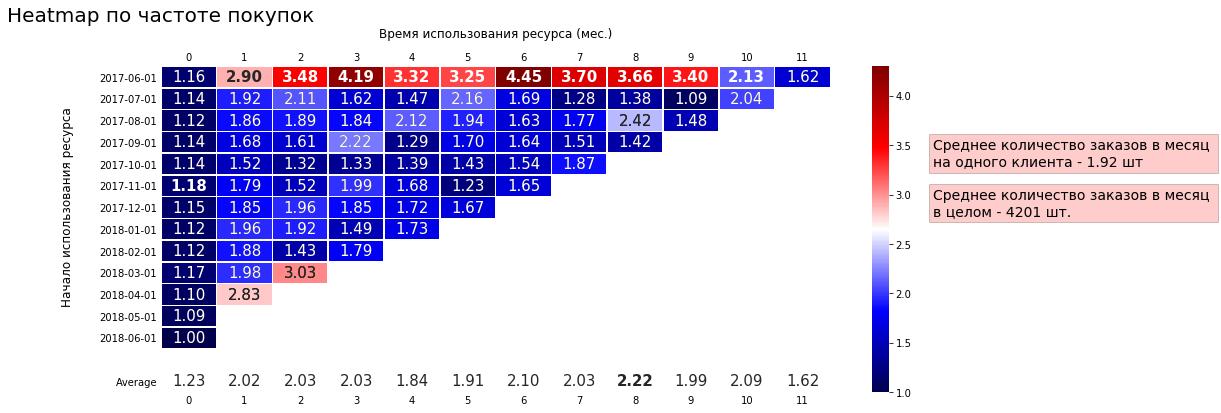

In [52]:
plot_heatmap(purchase_pivot, vmax=4.3, title='Heatmap по частоте покупок',
             annot_font_size=15,
             xlabel_text='Время использования ресурса (мес.)',
             ylabel_text='Начало использования ресурса')
mean_value = purchase_pivot.mean().mean()
purchase_count_mean_revenue = order_frequency['revenue'].count() / 12
order_mean_revenue = order_frequency['revenue'].mean()
text = plt.text(0.84, 0.65, 'Среднее количество заказов в месяц \nна одного клиента - {:.2f} шт'.
                format(mean_value),
                bbox=dict(facecolor='red', alpha=0.2),
                fontsize=14, transform=plt.gcf().transFigure)
text = plt.text(0.84, 0.535, 'Среднее количество заказов в месяц \nв целом - {:.0f} шт.'.
                format(purchase_count_mean_revenue),
                bbox=dict(facecolor='red', alpha=0.2),
                fontsize=14, transform=plt.gcf().transFigure)

### 4.3. Какой средний чек?.  <a name="paragraph4-3"></a>

Теперь узнаем, какой был средний чек по каждой когорте по месяцам:

In [53]:
first_orders_month = orders_monthly.groupby('uid').agg({'date_of_purchase': 'min'}).reset_index()
first_orders_month.columns = ['uid', 'first_purchase_date']

cohort_sizes = first_orders_month.groupby('first_purchase_date').agg({'uid': 'nunique'}).reset_index()
cohort_sizes.columns = ['first_purchase_date', 'n_buyers']

orders_first_orders_month = orders_monthly.merge(first_orders_month, on='uid')
cohorts = (orders_first_orders_month
                                    .groupby(['date_of_purchase', 'first_purchase_date'])
                                    .agg({'revenue': 'sum', 'uid': 'count'})
                                    .reset_index()
          )
mean_check = cohorts.merge(cohort_sizes, on='first_purchase_date')
time_diff = mean_check['date_of_purchase'] - mean_check['first_purchase_date']
mean_check['age'] = time_diff / np.timedelta64(1, 'M')
mean_check['age'] = mean_check['age'].round().astype('int')
mean_check['mean_check'] = mean_check['revenue']/mean_check['uid']
mean_check_pivot = mean_check.pivot_table(index="first_purchase_date", columns="age", values="mean_check")

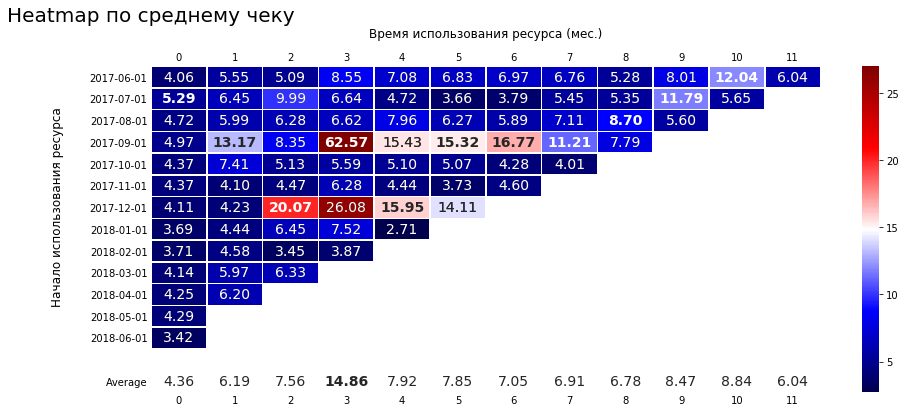

In [54]:
plot_heatmap(mean_check_pivot, vmax=27, title='Heatmap по среднему чеку',
             annot_font_size=14,
             xlabel_text='Время использования ресурса (мес.)',
             ylabel_text='Начало использования ресурса')

### 4.4. Сколько денег приносит в среднем один пользователь? (LTV при margin_rate = 0.5 и 1)  <a name="paragraph4-4"></a>

Рассчитаем LTV.

Посмотрим на LTV при коэффициенте маржинальности равным и 0.5, и 1 (хотя, с моей точки зрения, вариант со значением коэффициента маржинальности, равному 1, нереален, учитывая то, что J.K. в продаже билетов явно выступает посредником между исполнителем и клиентом, но в связи с тем, что этот показатель заранее не определен в задании, исследуем таких два варианта):

Напишем функцию для получения сводной таблицы по LTV при заданном margin_rate:

In [55]:
# функция для получения сводной таблицы LTV в зависимости от margin_rate

def get_LTV_pivot(margin_rate=0.5):

    first_orders_month = orders_monthly.groupby('uid').agg({'date_of_purchase': 'min'}).reset_index()
    first_orders_month.columns = ['uid', 'first_purchase_date']

    cohort_sizes = first_orders_month.groupby('first_purchase_date').agg({'uid': 'nunique'}).reset_index()
    cohort_sizes.columns = ['first_purchase_date', 'n_buyers']

    margin_rate = margin_rate

    orders_first_orders_month = orders_monthly.merge(first_orders_month, on='uid')
    cohorts = (orders_first_orders_month
                                        .groupby(['date_of_purchase', 'first_purchase_date'])
                                        .agg({'revenue': 'sum'})
                                        .reset_index()
              )
    LTV = cohorts.merge(cohort_sizes, on='first_purchase_date')
    LTV['gp'] = LTV['revenue'] * margin_rate
    LTV['age'] = (LTV['date_of_purchase'] - LTV['first_purchase_date']) / np.timedelta64(1, 'M')
    LTV['age'] = LTV['age'].round().astype('int')
    LTV['ltv'] = LTV['gp'] / LTV['n_buyers']
    
    LTV_pivot = LTV.pivot_table(index="first_purchase_date",
                columns="age",
                values="ltv",
                aggfunc='mean')
    
    return LTV, LTV_pivot

In [56]:
# функция для отрисовки LTV heatmap в зависимости от margin_rate

def LTV_heatmap(LTV_pivot, margin_rate=0.5):

    LTV_pivot.loc[:, ''] = np.nan
    LTV_pivot.loc[:, 'Cumsum'] = LTV_pivot.sum(axis=1)

    from matplotlib.colors import ListedColormap

    max_cumsum = LTV_pivot.loc[:, 'Cumsum'].max()
    max_in_each_column = np.max(LTV_pivot.iloc[:, :-1], axis=0)

    plt.figure(figsize=(15,6))

    # общая
    heatmap = sns.heatmap(LTV_pivot, fmt='.2f', annot=True, cmap=ListedColormap(['white']), 
                          vmax=2, linewidths=.5, cbar=False, 
                          mask=((LTV_pivot == max_cumsum) | (LTV_pivot == max_in_each_column)),
                          annot_kws={"size": '13'})

    # нежирные
    heatmap = sns.heatmap(LTV_pivot.iloc[:, :-1], fmt='.2f', annot=True, cmap='seismic', vmax=2, 
                          linewidths=.5, mask=LTV_pivot.iloc[:, :-1] == max_in_each_column, 
                          annot_kws={"size": '13'})

    # жирные
    heatmap = sns.heatmap(LTV_pivot.iloc[:, :-1], fmt='.2f', annot=True, cmap='seismic', vmax=2,
                          linewidths=.5, mask=LTV_pivot.iloc[:, :-1] != max_in_each_column,
                          annot_kws={"weight": "bold", "size": '13'},
                          cbar=False)

    # жирным общее максимальное
    heatmap = sns.heatmap(LTV_pivot, fmt='.2f', annot=True, cmap=ListedColormap(['white']), 
                          vmax=2, linewidths=.5, cbar=False,
                          mask=LTV_pivot != max_cumsum,
                          annot_kws={"weight": "bold", "size": '13'})

    heatmap.tick_params(axis="x", bottom=True, top=True, labelbottom=True, labeltop=True)

    heatmap.xaxis.set_label_position('top')
    heatmap.xaxis.labelpad = 15
    heatmap.yaxis.set_label_coords(-0.13, 0.57)
    y_labels = heatmap.set_yticklabels(LTV_pivot.index.date)
    heatmap.tick_params(length=0)
    title='LTV (margin_rate={})'.format(margin_rate)
    title = plt.title(title, x=0.0, fontsize=20)

### 4.4.1. LTV при margin_rate = 0.5.


Нарисуем heatmap LTV при margin_rate = 0.5:

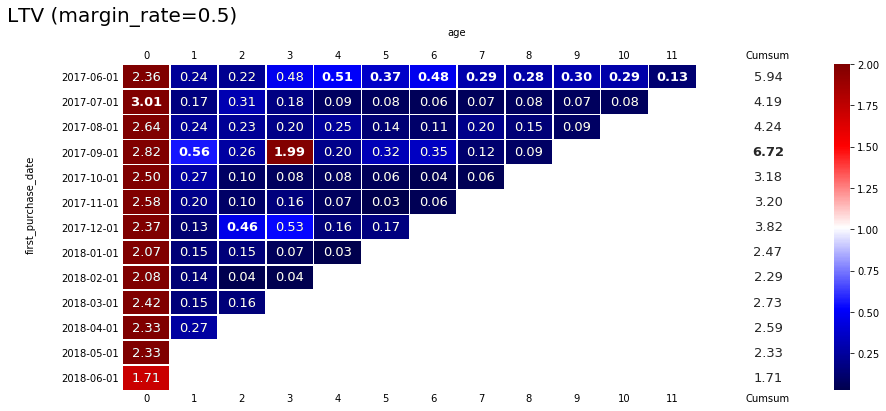

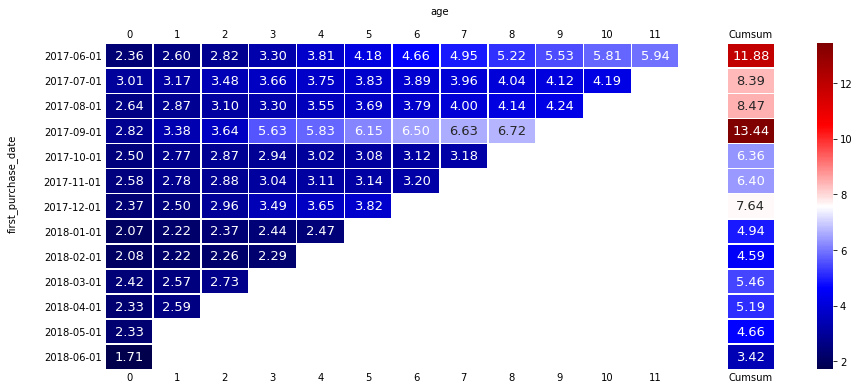

In [57]:
LTV_05, LTV_pivot_05 = get_LTV_pivot(0.5)

LTV_heatmap(LTV_pivot_05, 0.5)

df=LTV_pivot_05.cumsum(axis=1)
plt.figure(figsize=(15,6))
heatmap = sns.heatmap(df, annot=True, cmap='seismic', fmt='.2f', linewidths=.5, annot_kws={"size": '13'})
heatmap.tick_params(axis="x", bottom=True, top=True, labelbottom=True, labeltop=True)
heatmap.xaxis.set_label_position('top')
heatmap.xaxis.labelpad = 15
heatmap.yaxis.set_label_coords(-0.13, 0.57)
y_labels = heatmap.set_yticklabels(df.index.date)
heatmap.tick_params(length=0)

Для более подробного анализа был выведен как "точечный" LTV (значение LTV в каждый отдельный месяц - 1 график), так и накопительный (2 график). Можно заметить, что первые когорты (2017 года) были более "качественные", чем последующие - их накопительный LTV заметно выше, чем по остальным когортам.

Также можно отметить, что 1ая когорта была самая стабильная - практически в каждом месяце она показывала лучший результат по LTV среди всех когорт. Вызвано это тем, что именно эта когорта показывает лучший показатель Retention - как относительный, так и абсолютный.
По 4ой когорте (сентябрьской) необходимо исследовать 3ий месяц её жизни - там у нас аномальный всплеск месячного значения LTV практически до 2 т.р.

### 4.4.2. LTV при margin_rate = 1.

Теперь посмотрим на heatmap LTV при margin_rate = 1:

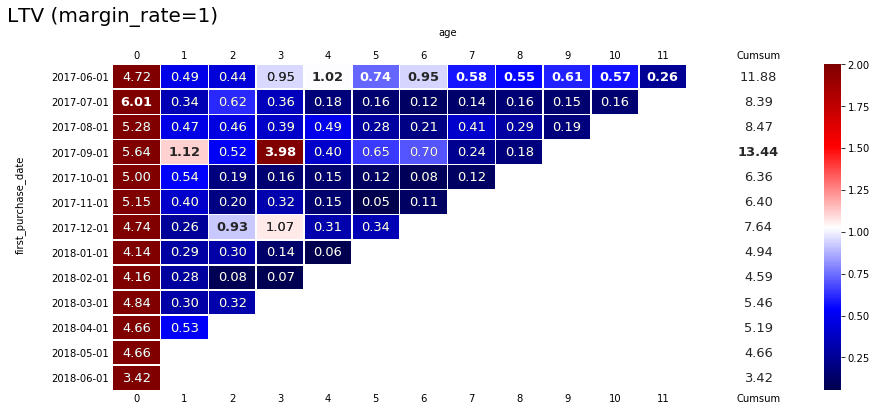

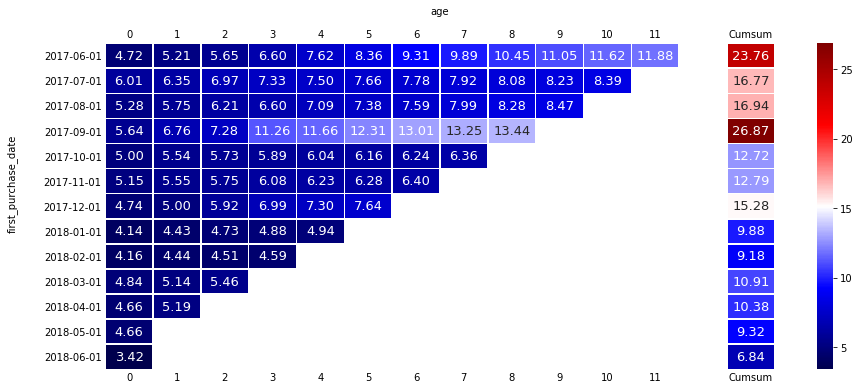

In [58]:
LTV_1, LTV_pivot_1 = get_LTV_pivot(1)
LTV_heatmap(LTV_pivot_1, 1)

df=LTV_pivot_1.cumsum(axis=1)
plt.figure(figsize=(15,6))
heatmap = sns.heatmap(df, annot=True, cmap='seismic', fmt='.2f', linewidths=.5, annot_kws={"size": '13'})
heatmap.tick_params(axis="x", bottom=True, top=True, labelbottom=True, labeltop=True)
heatmap.xaxis.set_label_position('top')
heatmap.xaxis.labelpad = 15
heatmap.yaxis.set_label_coords(-0.13, 0.57)
y_labels = heatmap.set_yticklabels(df.index.date)
heatmap.tick_params(length=0)

## 5. Анализ данных по маркетингу <a name="paragraph5"></a>

[Содержание](#introduction)

### 5.1 Сколько денег потратили? Всего / на каждый источник / по времени? <a name="paragraph5-1"></a>

Сначала подготовим данные и создадим датафрейм с 2 строками и 1 столбцом, где будут указаны суммарная выручка и суммарные затраты:

In [59]:
costs_copy = costs.copy()

costs_copy['date'] = costs_copy['date'].values.astype('datetime64[M]') 
costs_grouped = costs_copy.groupby('date').agg({'costs': 'sum'})

In [60]:
orders_grouped = orders_monthly.groupby('date_of_purchase').agg({'revenue': 'sum'})

In [61]:
data = {'summary': [round(orders_grouped.sum().values[0], 2),round(costs_grouped.sum().values[0], 2)]}
rev_costs = pd.DataFrame(data=data, index=['revenue', 'costs'])

### 5.1.1. График соотношения между затратами и выручкой.

Построим график соотношения между суммарными затратами и суммарной выручкой:

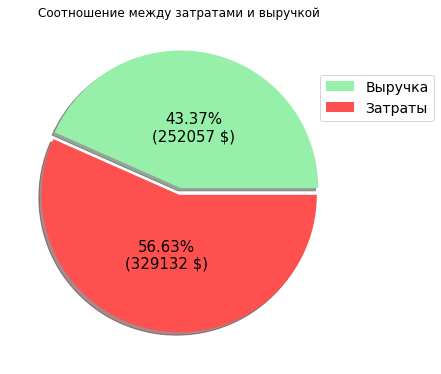

In [62]:

plt.style.use('seaborn-pastel')
summary = rev_costs.values.sum()

def func_pct(pct):
    value = float(pct/100.*summary)
    return "{:.2f}%\n({:.0f} $)".format(pct, value)

explode = (0.05, 0)  # сектор 'выручка' немного выдвинем

ax_pie = rev_costs.plot(kind='pie', y='summary', fontsize=15, use_index=False, shadow=True, explode=explode,
                        title = 'Соотношение между затратами и выручкой', pctdistance=0.45, figsize=(15,5), 
                        autopct=lambda pct: func_pct(pct), colors=['#97F0AA', '#ff5050'], labels=None)

plt.tight_layout(pad=0)

legend = ax_pie.legend(['Выручка', 'Затраты'], bbox_to_anchor=(0.89,0.87), prop={'size':14})
y_label = ax_pie.set_ylabel('')

Затраты превышают выручку, пока что бизнес работает в убыль. Это плохой знак, но пока нет возможности сказать, что ситуация критическая - вполне возможно, что эти вложения в чуть более длительном периоде времени окупятся, т.к. пользователи новых когорт ещё не имели достаточно времени показать нам свои результаты по выручке.

### 5.1.2. Затраты на рекламу по времени.

Посмтротрим на затраты на рекламу по времени в разбивке по рекламным каналам:

In [63]:
# покупатели по каналам
visits_sorted = visits.sort_values(by='session_start')

# затраты по каналам
costs_per_source = costs.groupby('source_id').agg({'costs': 'sum'})

# выручка по каналам
first_source_per_user = visits_sorted.groupby('uid').agg({'source id': 'first'})
client_per_source = orders.merge(first_source_per_user, on='uid')
client_per_source = client_per_source.groupby('source id').agg({'uid': 'nunique'})

# уникальные пользователи по каналам
uid_per_source = visits_sorted.groupby('source id').agg({'uid': 'nunique'})

rev_per_source = orders.merge(first_source_per_user, on='uid')
rev_per_source = rev_per_source.groupby('source id').agg({'revenue': 'sum'})

rev_uid_costs_per_source = pd.concat([costs_per_source, rev_per_source, 
                                      uid_per_source, client_per_source],axis=1).fillna(0)
rev_uid_costs_per_source = rev_uid_costs_per_source.reset_index()
rev_uid_costs_per_source['index'] = 'source ' + rev_uid_costs_per_source['index'].astype('str')
rev_uid_costs_per_source = rev_uid_costs_per_source.set_index('index')
rev_uid_costs_per_source.columns = ['costs', 'revenue', 'uid', 'clients']

source = ColumnDataSource(data=rev_uid_costs_per_source)

p = figure(x_range=rev_uid_costs_per_source.index.values, 
           x_axis_label="Канал рекламы", y_axis_label="т.р./чел",
           plot_width=950, plot_height=500, tools="tap, pan, wheel_zoom, reset",
           title="Затраты, выручка и кол-во привлеченных пользователей и покупателей по источникам рекламы")

costs_bar = p.vbar(x=dodge('index', -0.25, range=p.x_range), top='costs', width=0.15, source=source,
color="#e84d60", legend_label="costs", line_color="black", nonselection_fill_alpha=0.2)

rev_bar = p.vbar(x=dodge('index', -0.1, range=p.x_range), top='revenue', width=0.15, source=source,
color="#83C2BA", legend_label="revenue", line_color="black")

users_bar = p.vbar(x=dodge('index', 0.05, range=p.x_range), top='uid', width=0.15, source=source,
color="#BE94DC", legend_label="visitors", line_color="black")

clients_bar = p.vbar(x=dodge('index', 0.2, range=p.x_range), top='clients', width=0.15, source=source,
color="#D79B11", legend_label="buyers", line_color="black")

p.legend.click_policy="hide"
p.add_tools(HoverTool(renderers=[costs_bar], tooltips=[("Затраты", "@costs{1.0}")]))
p.add_tools(HoverTool(renderers=[users_bar], tooltips=[("Кол-во уник. пользователей", "@uid")]))
p.add_tools(HoverTool(renderers=[rev_bar], tooltips=[("Выручка", "@revenue{1.0}")]))
p.add_tools(HoverTool(renderers=[clients_bar], tooltips=[("Кол-во клиентов", "@clients")]))
p.yaxis[0].formatter = NumeralTickFormatter(format='0,0')

p.xgrid.grid_line_color = None

p.ygrid.band_fill_alpha = 0.05
p.ygrid.band_fill_color = "navy"

p.xaxis.major_label_text_font_size = "11pt"
p.yaxis.major_label_text_font_size = "11pt"

show(p)

In [64]:
rev_uid_costs_per_source.head(10)

,costs,revenue,uid,clients
index,,,,
source 1,20833.27,31090.55,18999,2899.0
source 2,42806.04,46923.61,26245,3506.0
source 3,141321.63,54511.24,74756,10473.0
source 4,61073.60,56696.83,83525,10296.0
source 5,51757.10,52624.02,56974,6931.0
source 6,0.00,0.00,6,0.0
source 7,0.00,1.22,34,1.0
source 9,5517.49,5759.40,9264,1088.0
source 10,5822.49,4450.33,8067,1329.0


В глаза сразу бросается <b>3ий</b> рекламный канал - в него мы делаем больше всего вложений (более 50% от суммы всех вложений в рекламу). Тем не менее, этот канал не является абсолютным лидером по размеру выручки - <b>4ый</b> канал с намного более меньшим рекламным бюджетом дает нам даже немного чуть большую выручку, чем <b>3ий</b> канал. С чуть меньшими рекламными затратами, но с примерно схожими показателями по выручке идут <b>2ой</b> и <b>5ый</b> каналы.<br/>

По количеству покупателей лидером всё же является 3ий канал, за ним следом идет <b>4ый</b>. Учитывая то, что по <b>4му</b> каналу выручка чуть выше, можно сказать, что средний чек клиента, привлеченного <b>4ым</b> каналом, выше, чем привлеченного 3им каналом.<br/>

Также есть совсем скромные 9 и 10 канал и практически нулевой 6ой и 7ой.

Тем не менее, по этому графику мы не можем делать никаких выводов по вопросу окупаемости каждого из каналов. Для этого необходимо посчитать <b>ROMI</b>, что мы и сделаем далее.

### 5.1.3. Затраты на рекламу по времени.

In [65]:
df_to_plot_costs_by_source = (costs
                              .groupby(['source_id', 'date'])['costs']
                              .sum()
                              .reset_index()
                             )
df_to_plot_costs_by_source['date'] = df_to_plot_costs_by_source['date'].astype('datetime64[M]')
df_to_plot_costs_by_source = df_to_plot_costs_by_source.groupby(['source_id', 'date'])['costs'].sum().reset_index()

source_costs_by_source = ColumnDataSource(df_to_plot_costs_by_source)

fig_costs = figure(x_axis_type='datetime', y_range=(0, 22000),
                   plot_width=750, plot_height=400,
                   title='Помесячные затраты по каналам', y_axis_label='т.р.')


sources = df_to_plot_costs_by_source['source_id'].unique()
colors = ['red', 'black', 'orange', 'brown', 'green', 'maroon', '#9FD129']
lines = ['line' + str(i) for i in range(1, len(sources)+1)]
circles = ['circle' + str(i) for i in range(1, len(sources)+1)]
plotted_lines = list()
plotted_circles = list()


sources_numbers = [1, 2, 3, 4, 5, 9, 10]
for i, source in enumerate(sources):
    for_data_source = df_to_plot_costs_by_source[df_to_plot_costs_by_source['source_id'] == source]
    source_costs_by_source = ColumnDataSource(for_data_source)
    label = 'Source ' + str(source)  
    lines[i] = fig_costs.line('date', y='costs', source=source_costs_by_source, line_width=2, 
                              color=colors[i], visible=True, legend_label=label)

fig_costs.legend.background_fill_alpha = 0.1
fig_costs.legend.location = "top_left"

fig_costs.y_range.start = 0
fig_costs.xaxis.major_label_orientation = 1
fig_costs.xgrid.grid_line_color = None
fig_costs.xaxis[0].ticker.desired_num_ticks = 15
fig_costs.xaxis.major_label_text_font_size = "10pt"
fig_costs.yaxis.major_label_text_font_size = "10pt"


l1 = layout([[fig_costs]])

show(l1)

Начиная с августа 2017г. вложения в рекламу начали увеличиваться. В ноябре того же года они достигли пика практически по всем рекланым каналам.

Самый активный период вливаний денег в рекламу - с октября 2017г. по март 2018г. (включительно).<br/>
В остальные периоды активность по заказу рекламы есть, но уже значительно ниже.

### 5.1.5. Сколько стоило привлечение одного покупателя из каждого источника?

Выведем информацию по стоимости привлечения одного клиента по каждому из каналов рекламы:

In [66]:
rev_uid_costs_per_source['price_for_client'] = rev_uid_costs_per_source['costs']/rev_uid_costs_per_source['clients']
rev_uid_costs_per_source['price_for_client'] = rev_uid_costs_per_source['price_for_client'].round(2)
rev_uid_costs_per_source['price_for_client'].sort_values(ascending=False).to_frame()

,price_for_client
index,
source 3,13.49
source 2,12.21
source 5,7.47
source 1,7.19
source 4,5.93
source 9,5.07
source 10,4.38
source 7,0.00
source 6,NaN


Ожидаемо, что лидер по дороговизне привлечения одного пользователя - 3 канал. За ним идет 2 канал, но он себя в окупает, в отличие от идущих за ним 4 и 5.

### 5.1.6. Выводы по использованию рекламных каналов

* <b>1, 2, 5 и 9 каналы</b> работают достаточно хорошо: выручка выше расхода, при этом есть пусть не огромный, но приток новых пользователей, который сопоставим с размером вложенных средств;
* <b>3ий канал</b>, в который мы вкладываемся больше всего, убыточен - 44000 т.р. дохода против 140000 т.р. расхода, при этом он даже не лидер по количеству привлеченных клиентов, но привлеченный с его помощью пользователь самый дорогой;
* <b>4ый канал</b> также невыгоден, т.к. расходы превышают доход, тем не менее он является лидером по количеству привлеченных пользователей, даже по сравнению с 3 каналом, в который вложено в 2,5 раза больше;
* <b>6 и 7 канал</b> не являются затратными (мы в них не вкладываемся), на двоих они привлекли 40 новых пользователей, из них только 1 стал клиентом, и он принес нам 1,22 т.р. выручки;
* <b>10 канал</b> работает "в минус".
<br/><br/>

В связи с этим, рекомендутся перераспределить вложения в рекламные каналы и с <b>3 канала</b> часть средств направить на самые перспективные <b>1</b> (в первую очередь) и <b>2</b>. По <b>3</b> и <b>4 каналам</b> необходимо провести исследования и разобраться, почему по ним такая низкая конверсия посетителя в покупателя, и провести соответствующие мероприятия для улучшения этих показателей.<br/> <br/> 

В целом, рекламную кампанию нельзя назвать успешной.

### 5.2 Анализ посещаемости ресурса по типу устройства <a name="paragraph5-2"></a>

In [67]:
visits_by_device = visits.groupby('device').agg({'uid': 'count'})

In [68]:
visits_by_device.head()

,uid
device,
desktop,262567
touch,96833


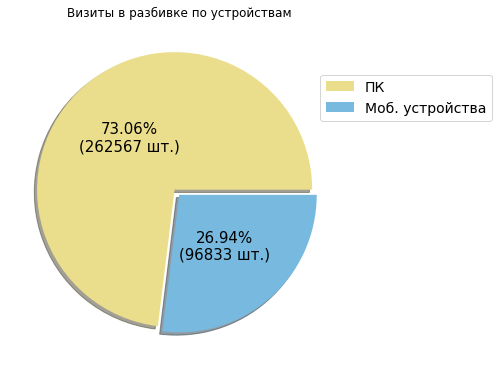

In [69]:
summary = visits_by_device.values.sum()
def func_pct(pct):
    value = float(pct/100.*summary)
    return "{:.2f}%\n({:.0f} шт.)".format(pct, value)

explode = (0.05, 0)

ax_pie = visits_by_device.plot(kind='pie', y='uid', fontsize=15, use_index=False, shadow=True, explode=explode,
                        title = 'Визиты в разбивке по устройствам', pctdistance=0.5, figsize=(15,5), 
                        autopct=lambda pct: func_pct(pct), colors=['#EADD8B', '#78B9DF'], labels=None)

plt.tight_layout(pad=0)

legend = ax_pie.legend(['ПК', 'Моб. устройства'], bbox_to_anchor=(0.89,0.87), prop={'size':14})
y_label = ax_pie.set_ylabel('')

**Вывод:** Приблизительно 75% посещений нашего ресурса совершены с настолького ПК. Учитывая нынешнее время, 25 % посещаемости с мобильных устройств - довольно слабый показатель. Вероятно, причиной тому является тот факт, что отдельного мобильного приложения не существует, а сам сайт не так удобен для использования с мобильного устройства. 

### 5.3 САС, ROMI. <a name="paragraph5-3"></a>

### 5.3.1. Функции для heatmap и stacked-bar.

In [70]:
# LTV по каналам рекламы
def get_LTV_pivot_by_source(source, margin_rate=0.5):
    visits_sorted = visits.sort_values(by='session_start')
    first_source_per_user = (visits_sorted
                                 .groupby('uid')
                                 .agg({'source id': 'first'})
                                 .reset_index()
                            )
    chosen_buyers = first_source_per_user[first_source_per_user['source id'] == source]
    visits_by_source = orders_monthly.merge(chosen_buyers, on='uid')
    mean_check = round(visits_by_source['revenue'].mean(), 2)
    visits_by_source['date_of_purchase'] = visits_by_source['date_of_purchase'].astype('datetime64[M]')
    
    first_orders_month = visits_by_source.groupby('uid').agg({'date_of_purchase': 'min'}).reset_index()
    first_orders_month.columns = ['uid', 'first_purchase_date']

    cohort_sizes = first_orders_month.groupby('first_purchase_date').agg({'uid': 'nunique'}).reset_index()
    cohort_sizes.columns = ['first_purchase_date', 'n_buyers']
    orders_first_orders_month = visits_by_source.merge(first_orders_month, on='uid')
    cohorts = (orders_first_orders_month
                                    .groupby(['date_of_purchase', 'first_purchase_date'])
                                    .agg({'revenue': 'sum'})
                                    .reset_index()
              )
    if len(cohorts) > 0:
        LTV = cohorts.merge(cohort_sizes, on='first_purchase_date')
        LTV['gp'] = LTV['revenue'] * margin_rate
        LTV['age'] = (LTV['date_of_purchase'] - LTV['first_purchase_date']) / np.timedelta64(1, 'M')
        LTV['age'] = LTV['age'].round().astype('int')
        LTV['ltv'] = LTV['gp'] / LTV['n_buyers']
        
        LTV = LTV.query('age < 6 and first_purchase_date <= "2017-11-01"')

        LTV_pivot = LTV.pivot_table(index="first_purchase_date",
                    columns="age",
                    values="ltv",
                    aggfunc='mean').reset_index()
        
        all_buyers = sum(LTV['n_buyers'].unique())
        
        mean_check_prep = LTV.groupby('first_purchase_date').mean()
        mean_check = round(sum(mean_check_prep['revenue'].tolist()) / sum(mean_check_prep['n_buyers'].tolist()), 2)

        return LTV, LTV_pivot, all_buyers, mean_check
    
    
# ROMI по каналам рекламы    
def get_ROMI_pivot_by_source(LTV, source, costs=costs, margin_rate=0.5):

    costs_cac = costs[costs['source_id'] == source].copy()
    costs_cac['date'] = costs_cac['date'].astype('datetime64[M]')
    all_costs = costs_cac.groupby('date')['costs'].sum().to_frame().reset_index()
    all_costs = all_costs.query('date <= "2017-11-01"')
    sum_costs = round(all_costs.sum().values[0], 2)
    
    final_cac = LTV.merge(all_costs, left_on='first_purchase_date', right_on='date')
    final_cac['cac'] = final_cac['costs']/final_cac['n_buyers']
    final_cac['romi'] = final_cac['ltv']/final_cac['cac']
    sum_gp = round(final_cac['gp'].sum(), 2)
    profit = round(sum_gp - sum_costs, 2)

    romi_pivot = final_cac.pivot_table(index='first_purchase_date', columns='age',
                                       values='romi').round(2)

    romi_pivot_cumsum = romi_pivot.cumsum(axis=1).round(2)
    
    if len(romi_pivot.columns) < 12:
        for i in range(len(romi_pivot.columns), 12):
            romi_pivot.loc[:, i] = np.NaN

    return final_cac, romi_pivot, romi_pivot_cumsum, sum_gp, sum_costs, profit

In [71]:
# функция для вывода heatmap ROMI

def romi_heatmap(romi_pivot, margin_rate=0.5, title=True, return_romi_mean=False):
    vmax = romi_pivot.max().max()
    romi_pivot.loc[:, ''] = np.nan
    romi_pivot.loc[:, 'Cumsum'] = romi_pivot.sum(axis=1)
    romi_mean = round(romi_pivot.loc[:, 'Cumsum'].mean(), 2)

    from matplotlib.colors import ListedColormap

    max_cumsum = romi_pivot.loc[:, 'Cumsum'].max()
    max_in_each_column = np.max(romi_pivot.iloc[:, :-1], axis=0)

    plt.figure(figsize=(15,5))

    # общая
    heatmap = sns.heatmap(romi_pivot, fmt='.2f', annot=True, cmap=ListedColormap(['white']), 
                          vmax=0.5, linewidths=.5, cbar=False, 
                          mask=((romi_pivot == max_cumsum) | (romi_pivot == max_in_each_column)),
                          annot_kws={"size": '13'})

    # нежирные
    heatmap = sns.heatmap(romi_pivot.iloc[:, :-1], fmt='.2f', annot=True, cmap='seismic', vmax=vmax, 
                          linewidths=.5,mask=romi_pivot.iloc[:, :-1] == max_in_each_column, 
                          annot_kws={"size": '13'})

    # жирные
    heatmap = sns.heatmap(romi_pivot.iloc[:, :-1], fmt='.2f', annot=True, cmap='seismic', vmax=vmax,
                          linewidths=.5,mask=romi_pivot.iloc[:, :-1] != max_in_each_column,
                          annot_kws={"weight": "bold", "size": '13'},
                          cbar=False)

    # жирным общее максимальное
    heatmap = sns.heatmap(romi_pivot, fmt='.2f', annot=True, cmap=ListedColormap(['white']), 
                          vmax=0.5, linewidths=.5, cbar=False,
                          mask=romi_pivot != max_cumsum,
                          annot_kws={"weight": "bold", "size": '13'})

    heatmap.tick_params(axis="x", bottom=True, top=True, labelbottom=True, labeltop=True)

    heatmap.xaxis.set_label_position('top')
    heatmap.xaxis.labelpad = 15
    heatmap.yaxis.set_label_coords(-0.13, 0.57)
    y_labels = heatmap.set_yticklabels(romi_pivot.index.date)
    heatmap.tick_params(length=0)
    if title:
        title='ROMI (margin_rate={})'.format(margin_rate)
        title = plt.title(title, x=0.0, fontsize=20)
    if return_romi_mean:
        return romi_mean

In [72]:
# функция для построения stackedbar-plot

def romi_stacked_bar(romi_pivot, margin_rate=0.5, show_plot=True):
    romi_stacked = romi_pivot.fillna(0).reset_index()
    romi_stacked['first_purchase_date'] = (romi_stacked['first_purchase_date']
                                           .apply(lambda x: str(x).split(' 00:00:00')[0])
                                          )
    romi_stacked['first_purchase_date'] = (romi_stacked['first_purchase_date']
                                           .apply(lambda x: str(x).split('-')[0] + '-' + str(x).split('-')[1])
                                          )
    romi_stacked = romi_stacked.rename(columns={'first_purchase_date': 'index'}).set_index('index')


    dates = romi_stacked.index.values.tolist()
    ages = [str(age) for age in romi_stacked.columns.values]
    colors = ["#c9d9d3", "#718dbf", "#e84d60", 'skyblue', 'steelblue', 'blanchedalmond',
              'khaki', 'peru', 'lightgreen', 'plum', 'salmon', '#777E83'][:6]

    #data1
    data1 = {'index' : dates[::-1]}
    for age in ages:
        data1[age] = romi_stacked[int(age)].tolist()[::-1]
    
    columns_sum = romi_pivot.cumsum(axis=1).round(2)
    max_sum_per_col = columns_sum.max()
    max_sum = max_sum_per_col.max()
    if max_sum < 1:
        x_max = 1.2
    else:
        x_max = max_sum * 1.1
    
    y_range = dates[::-1]
    
    p = figure(y_range=y_range, plot_height=430, plot_width=700, 
               x_range=(0, x_max), title="Накопленный ROMI по когортам\n(margin_rate={})".format(margin_rate),
               tools="hover, wheel_zoom, pan, reset", tooltips="$name: @$name{1.11}")

    vbar = p.hbar_stack(ages, y='index', height=0.9, color=colors, source=data1, line_color="black")

    green_box = BoxAnnotation(left=1.0, fill_color='green', fill_alpha=0.2)
    p.add_layout(green_box)
    
    p.yaxis.axis_label = 'Когорты'
    p.xaxis.axis_label = 'Накопленное значение ROMI'
    p.x_range.start = 0
    p.y_range.range_padding = 0.1
    p.ygrid.grid_line_color = None
    p.axis.minor_tick_line_color = None
    p.outline_line_color = None

    p.yaxis.major_label_text_font_size = "11pt"
    p.yaxis.major_label_text_font_style = "bold"
    p.xaxis.major_label_text_font_size = "11pt"
    p.xaxis.major_label_text_font_style = "bold"
    p.xaxis[0].ticker.desired_num_ticks = 8
    p.min_border_left = 0
    p.min_border_right = 0
    p.min_border_top = 0
    p.min_border_bottom = 0

    legend = Legend(items=[(age, [part]) for (age, part) in zip(ages, vbar)], location=(0, 0), 
                    orientation="horizontal")
    p.add_layout(legend, 'above')
    p.legend.click_policy="hide"
    p.legend.title = 'Месяц\nжизни\nкогорты'

    p.legend.background_fill_alpha = 0
    p.legend.margin = 0
    
    if show_plot:
        show(p)
    else:
        return p

In [73]:
# визуализация ROMI по каналам рекламы (в зависимости от margin_rate)

def final_ROMI_source_output(margin_rate=0.5):
    sources = [1, 2, 3, 4, 5, 9, 10]
    tabs = list()

    for source in sources:
        LTV, LTV_pivot, all_buyers, mean_check = get_LTV_pivot_by_source(source, margin_rate=margin_rate)
        final_cac, source_romi_pivot, _, sum_gp, sum_costs, profit = get_ROMI_pivot_by_source(LTV, source)
        
        source_romi_pivot = source_romi_pivot.iloc[:6, :6].fillna(0)
        source_romi_stacked_bar = romi_stacked_bar(source_romi_pivot, margin_rate=margin_rate, show_plot=False)
        text_common = """<h3>Итог по 6 месяцам:</h3><br/>
                      <font size="3"><b>ROMI ср.:</b> {romi_mean}</font><br/>
                      <b>CAC ср.:</b> {cac_mean} т.р./чел.<br/>
                      <b>LTV ср.:</b> {ltv_mean} т.р./чел.<br/><br/>
                      <b>Общее число клиентов:</b> {all_buyers} чел.<br/>
                      <b>Средний чек:</b> {mean_check} тыс.руб.<br/><br/>
                      <b>Прибыль:</b> {sum_gp} тыс.руб.<br/>
                      <b>Затраты:</b> {sum_costs} тыс.руб.<br/><br/>
                      <b>Итог:<br/>"""
        
        
        
        cac_mean = round(final_cac['cac'].mean(), 2)
        romi_mean = romi_heatmap(source_romi_pivot, margin_rate=margin_rate, title=False, return_romi_mean=True)
        ltv_mean = round(romi_mean * cac_mean, 2)
        
        if profit >= 0:
            text = text_common + """<font color="green"><font size=3><b>{profit}</font> 
                                    тыс.руб.</font></b><br/><br/>"""
        else:
            text = text_common + """<font color="red"><font size=3><b>{profit}</font> 
                                    тыс.руб.</font></b><br/><br/>"""
        
        
        info = Div(text=text.format(cac_mean=cac_mean, ltv_mean=ltv_mean, romi_mean=romi_mean, all_buyers=all_buyers, 
                                    mean_check=mean_check, sum_gp=sum_gp, sum_costs=sum_costs, profit=profit))
        
        
        buf = io.BytesIO()
        plt.savefig(buf, format='png')
        image_base64 = base64.b64encode(buf.getvalue()).decode('utf-8').replace('\n', '')
        imgStr = "data:image/png;base64, "
        imgStr += image_base64
        buf.close()
        plt.close()
        info_heatmap = Div(text="""<img src="{imgStr}"/>""".format(imgStr=imgStr))
        time.sleep(1)
        
        romiplot_heatmap = column(row(source_romi_stacked_bar, info), info_heatmap)
        
#        time.sleep(0.3)

        l = layout([[romiplot_heatmap]])
        tab = Panel(child=l, title='Source {}'.format(source))
        tabs.append(tab)

    tabs_to_show = Tabs(tabs=tabs)
    show(tabs_to_show)

### 4.3.2. Margin_rate = 0.5:

Смотрим на показатели ROMI при margin_rate = 0.5:

In [74]:
final_ROMI_source_output(margin_rate=0.5)

<b><font size="4">Выводы:</font></b><br/>
* при <b>margin_rate = 0.5</b> все каналы рекламы оказались убыточными, тем не менее, в некоторых из них есть "яркие" когорты пользователей (которые были привлечены на наш ресурс именно этими рекламными каналами), которые себя окупили.

Опишем их более подробно:

<table border="1" cellspacing="0" cellpadding="0">
<tr>
<td><b>Канал</b></td>
<td><b>ROMI</b></td>
<td><b>CAC, т.р./чел.</b></td>
<td><b>LTV, т.р./чел.</b></td>
<td><b>Клиенты, <br/>чел.</b></td>
<td><b>Ср. чек.,<br/> тыс.руб.</b></td>
<td><b>Прибыль, <br/>руб.</b></td>
<td><b>Затраты, <br/>руб.</b></td>   
<td><b>Прибыль, руб.</b></td>   
<td><b>Итог</b></td>  
<tr>
<td><b>1</b></td>
<td><b><font color="red">0.97</font></b></td>
<td>7.0</td>
<td>6.79</td>
<td>1354</td>
<td>2.01</td>
<td>8170.12</td>
<td>9413.22</td>
<td>-1243.1</td>
<td>Канал на рассматриваемом периоде убыточен, тем не менее, <b>ROMI</b> близок к 1, более того, первые 2 когорты выглядят очень хорошо - они себя окупили очень уверенно.</td>
<tr>
<td> <b>2</b></td>
<td><b><font color="red">0.47</font></b></td>
<td>12.53</td>
<td>5.89</td>
<td>1581</td>
<td>1.99</td>
<td>9426.38</td>
<td>19649.88</td>
<td>-10223.5</td>
<td>Канал убыточен. По нему есть интересная 4ая (сентябрьская) когорта, которая в более длительном периоде времени должна окупиться. Необходимо её исследовать.</td>
<tr>
<td> <b>3</b></td>
<td><b><font color="red">0.2</font></b></td>
<td>14.29</td>
<td>2.86</td>
<td>4636</td>
<td>0.96</td>
<td>13312.56</td>
<td>64275.69</td>
<td>-50963.13</td>
<td>Канал безнадежно убыточен. Самый низкий показатель <b>ROMI</b> среди всех каналов. При этом в этот канал мы делаем больше всего вложений.</td>
<tr>
<td> <b>4</b></td>
<td><b><font color="red">0.46</font></b></td>
<td>7.29</td>
<td>3.35</td>
<td>4207</td>
<td>1.01</td>
<td>12795.6</td>
<td>27263.81</td>
<td>-14468.21</td>
<td>Канал также убыточен, тем не менее, есть интересная 6 когорта, которая достигла по показателю <b>ROMI</b> значения в 0.7 единиц. На более длинном промежутке времени должна окупиться.</td>
<tr>
<td> <b>5</b></td>
<td><b><font color="red">0.75</font></b></td>
<td>6.96</td>
<td>5.22</td>
<td>3394</td>
<td>1.63</td>
<td>16593.37</td>
<td>23741.42</td>
<td>-7148.05</td>
<td>Пусть среднее накопленное значение <b>ROMI</b> за 6 месяцев по всем когортам меньше 1, есть очень и очень сильная 4ая когорта (<b>ROMI</b> близок к 2 - лучший показатель среди всех когорт по всем каналам) и очень обнадеживающая 3ья. </td>
<tr>
<td> <b>9</b></td>
<td><b><font color="red">0.64</font></b></td>
<td>4.74</td>
<td>3.03</td>
<td>539</td>
<td>0.99</td>
<td>1601.89</td>
<td>2544.9</td>
<td>-943.01</td>
<td>Один из самых скромных каналов по размеру вложений. Канал, на данный момент, убыточен, но все когорты этого канала выглядят довольно уверенно и в более длинной перспективе способны окупиться.</td>
<tr>
<td> <b>10</b></td>
<td><b><font color="red">0.37</font></b></td>
<td>5.07</td>
<td>1.88</td>
<td>606</td>
<td>0.82</td>
<td>1307.6</td>
<td>2756.88</td>
<td>-1719.28</td>
<td>Один из самых скромных каналов по размеру вложений. Канал с малообнадеживающим итоговым средним показателем накопленного <b>ROMI</b></td>
</table>

<br/>

### 4.3.3. Margin_rate = 1:

In [75]:
final_ROMI_source_output(margin_rate=1)

<b><font size="4">Выводы:</font></b><br/>
* при <b>margin_rate = 1</b> 3 канала (1, 5, 9) окупились, остальные каналы рекламы оказались убыточными, однако, есть некоторые каналы (2 и 4), <b>ROMI</b> которых близок к значению 1.

Опишем положение дел более подробно:

<table border="1" cellspacing="0" cellpadding="0">
<tr>
<td><b>Канал</b></td>
<td><b>ROMI</b></td>
<td><b>CAC, т.р./чел.</b></td>
<td><b>LTV, т.р./чел.</b></td>
<td><b>Клиенты, <br/>чел.</b></td>
<td><b>Ср. чек.,<br/> тыс.руб.</b></td>
<td><b>Прибыль, <br/>руб.</b></td>
<td><b>Затраты, <br/>руб.</b></td>   
<td><b>Прибыль, руб.</b></td>   
<td><b>Итог</b></td>  
<tr>
<td><b>1</b></td>
<td><b><font color="green">1.93</font></b></td>
<td>7.0</td>
<td>13.51</td>
<td>1354</td>
<td>2.01</td>
<td>16340.23</td>
<td>9413.22</td>
<td>6927.01</td>
<td>Канал на рассматриваемом периоде при коэффициенте маржинальности равном 1 окупился. Выглядит очень уверенно - лучший канал с точки зрения окупаемости.</td>
<tr>
<td> <b>2</b></td>
<td><b><font color="red">0.95</font></b></td>
<td>12.53</td>
<td>11.9</td>
<td>1581</td>
<td>1.99</td>
<td>18852.75</td>
<td>19649.88</td>
<td>-797.13</td>
<td>Канал убыточен. Тем не менее, значение <b>ROMI</b> близко к 1. Можно быть уверенным, что в ближайшей временной перспективе этот канал выйдет в "плюс".</td>
<tr>
<td> <b>3</b></td>
<td><b><font color="red">0.43</font></b></td>
<td>14.29</td>
<td>6.14</td>
<td>4636</td>
<td>0.96</td>
<td>26625.12</td>
<td>64275.69</td>
<td>-37650.57</td>
<td>Канал безнадежно убыточен даже про margin_rate = 1. Так же самый низкий показатель <b>ROMI</b> среди всех каналов.</td>
<tr>
<td> <b>4</b></td>
<td><b><font color="red">0.91</font></b></td>
<td>7.29</td>
<td>6.63</td>
<td>4207</td>
<td>1.01</td>
<td>25591.2</td>
<td>27263.81</td>
<td>-1672.61</td>
<td>Канал также убыточен, тем не менее, значение <b>ROMI</b> равно 0.91, т.е. в ближайшей перспективе канал должен окупиться.</td>
<tr>
<td> <b>5</b></td>
<td><b><font color="green">1.51</font></b></td>
<td>6.96</td>
<td>10.51</td>
<td>3394</td>
<td>1.63</td>
<td>33186.7</td>
<td>23741.42</td>
<td>9445.31</td>
<td>При коэффициенте маржинальности равном 1 канал окупился. Выглядит довольно уверенно - практически все когорты близки к значению в 1 или уже ушли в "зелёную зону" (<b>ROMI</b> >= 1).</td>
<tr>
<td> <b>9</b></td>
<td><b><font color="green">1.27</font></b></td>
<td>4.74</td>
<td>6.02</td>
<td>539</td>
<td>0.99</td>
<td>3203.77</td>
<td>2544.9</td>
<td>658.87</td>
<td>Один из самых скромных каналов по размеру вложений. Тем не менее, канал окупился, причем почти по всем когортам. Если бы мы взяли более длинный отрезок времени (+1-2 месяца) и рассматривали его, то, скорее всего, окупились бы все когорты по этому каналу.</td>
<tr>
<td> <b>10</b></td>
<td><b><font color="red">0.74</font></b></td>
<td>5.07</td>
<td>3.75</td>
<td>606</td>
<td>0.82</td>
<td>2075.19</td>
<td>2756.88</td>
<td>-681.69</td>
<td>Один из самых скромных каналов по размеру вложений. Не окупается даже при margin_rate = 1.</td>
</table>

## 6. Общий вывод <a name="paragraph6"></a>

[Содержание](#introduction)

### 6.1. Продукт и продажи.

<b>Retention</b> у <b>J.K.</b> очень низкий (около 4%). Большинство сессий имеют длительность до 2-3 минут, т.е. люди заходят на ресурс и, сделав пару щелчков, выходят оттуда. Большая часть клиентов после первой покупки уже не возвращаются. Оставшиеся же совершают в среднем 2 покупки в месяц.<br/>
Тем не менее, есть одна когорта, самая первая, которая ведет себя необычно по сравнению со всеми остальными когортами: её <b>Retention</b> заметно выше, чем у остальных когорт (6%), и совершают больше покупок в месяц (~ 4). Необходимо тщательно исследовать эту когорту: как они узнали о ресурсе, что заставляет их продолжать им пользоваться, почему среди прочих всех подобных билетных агрегаторов они выбирают <b>J.K.</b>.

### 6.2. Маркетинг.

Необходимо перераспределить вложения в рекламные каналы и сместить акцент с 3 канала, который особо убыточен для компании, на каналы 1 и 5, которые являются довольно перспективными, учитывая текущую отдачу при текущих вложениях.  По 2, 3 и 4 каналам необходимо провести дополнительные исследования и выяснить причины настолько низкой конверсии в покупателя и проработать и провести необходимые мероприятия для исправления ситуации, т.к. в них мы также делаем довольно солидные рекламные вливания. Также стоит обратить внимание на одну из когорт (4ая, сентябрьская) 5го рекламного канала (по которым ROMI > 1) для оценки рекламной кампании того периода, когда эта когорта образовалась, для сравнения её с остальными, менее успешными периодами этих рекламных каналов.